# <b>Deep Learning Models for Stock Price Predictions </b>

### <b>1.) Introduction</b>

This project is part of the QF634 module - Applied Quantitative Research Method, in the Master’s in Quantitative Finance program at Singapore Management University. Under the guidance of Professor Lim Kian Guan, the project explores the use of advanced deep learning models, including LSTM (Long Short-Term Memory), GRU (Gated Recurrent Unit), and GAN (Generative Adversarial Networks), to predict stock prices based on historical data and technical indicators.

Stock price prediction is a critical task in the financial industry, as accurate predictions can significantly impact investment decisions. By applying these deep learning models, this project aims to evaluate their effectiveness in capturing the complexities of financial time series data and to identify the most suitable model for reliable stock price forecasting.

### <b>2.) Objectives</b>

- To preprocess historical stock data and relevant features.
- To build and train LSTM, GRU, and GAN models for predicting stock prices.
- To evaluate and compare the performance of these models using appropriate metrics.
- To visualize the predicted stock prices against actual values to assess model accuracy.

### <b>3.) Dataset Description</b>

In this project, three stocks—Apple Inc. (AAPL), eBay Inc. (EBAY), and Starbucks Corporation (SBUX)—were selected from different industries within the US stock markets to observe how industry differences influence stock price predictions. The dataset consists of historical closing prices from January 1, 2013, to December 31, 2022, sourced from the yfinance library. The model's target variable is the closing price. A total of 15 representative features were chosen based on their predictive power, divided into three categories: basic features, technical indicators, and fundamental indicators. Basic features include historical prices and volume, while technical indicators such as the 21-day simple moving average, MACD, RSI, and Bollinger Bands were calculated from the closing prices. Fundamental indicators included key financial metrics like earnings per share and net profit margin, as well as macroeconomic factors such as the Federal funds rate and commodity prices. This diverse set of features was designed to enhance the model's predictive performance by capturing various aspects of market behavior and financial health.

In [1]:
# 3.1) import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime as dt
import re
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import warnings
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
warnings.filterwarnings('ignore')

In [2]:
# 3.2) import historical stock prices

# specify tickers, start and end date
tickers = ['SBUX', 'EBAY', 'AAPL']
start_date = dt.datetime(2013,1,1)
end_date = dt.datetime(2023,1,1)

# import historical prices
targeted_price = ['Close']

starbuck = pdr.get_data_yahoo(tickers[0], start_date, end_date)
ebay = pdr.get_data_yahoo(tickers[1], start_date, end_date)
apple = pdr.get_data_yahoo(tickers[2], start_date, end_date)

starbuck = starbuck[targeted_price]
ebay = ebay[targeted_price]
apple = apple[targeted_price]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# 3.3) import fundamental datasets and attach them to the dataframe
# - Earnings per share excluding extraordinary items - "epsf12"
# - Total assets = "atq"; Total liabilities = "ltq"
# - Common shares used to calculate earnings per share - 12 months moving - "cshfd12"
# - Revenue total - "revtq" and "revty"
# - Report date of quarterly earnings - "rdq"

# 3.3.1) Import and separate the data for each stock
fundamental_data = pd.read_csv('Fundamental_data.csv')
starbuck_fundamental = fundamental_data[fundamental_data['tic'] == 'SBUX']
ebay_fundamental = fundamental_data[fundamental_data['tic'] == 'EBAY']
apple_fundamental = fundamental_data[fundamental_data['tic'] == 'AAPL']

# 3.3.2) Set report date as the index and filter only the data that will be used
starbuck_fundamental = starbuck_fundamental[['datadate','epsf12','atq','ltq','cshoq','revtq','revty','rdq','epspxq']]
ebay_fundamental = ebay_fundamental[['datadate','epsf12','atq','ltq','cshoq','revtq','revty','rdq','epspxq']]
apple_fundamental = apple_fundamental[['datadate','epsf12','atq','ltq','cshoq','revtq','revty','rdq','epspxq']]

# 3.3.3) Filter to get only report dates before 2013 and before 2023
start_year = 2012
end_year = 2022

starbuck_fundamental['rdq'] = pd.to_datetime(starbuck_fundamental['rdq'])
ebay_fundamental['rdq'] = pd.to_datetime(ebay_fundamental['rdq'])
apple_fundamental['rdq'] = pd.to_datetime(apple_fundamental['rdq'])

starbuck_fundamental = starbuck_fundamental[starbuck_fundamental['rdq'].dt.year.between(start_year, end_year)]
ebay_fundamental = ebay_fundamental[ebay_fundamental['rdq'].dt.year.between(start_year, end_year)]
apple_fundamental = apple_fundamental[apple_fundamental['rdq'].dt.year.between(start_year, end_year)]

starbuck_fundamental = starbuck_fundamental.iloc[3:]
ebay_fundamental = ebay_fundamental.iloc[3:]
apple_fundamental = apple_fundamental.iloc[3:]

# 3.3.4) Rename the columns
new_column_names = {
    'datadate':'date',
    'epsf12':'eps_ttm',
    'atq' : 'total_asset',
    'ltq' : 'total_liabilities',
    'cshoq' : 'common_share',
    'revtq' : 'revenue_q',
    'rdq' : 'date_announced',
    'epspxq' : 'eps_q'
    }

starbuck_fundamental.rename(columns = new_column_names, inplace = True)
ebay_fundamental.rename(columns = new_column_names, inplace = True)
apple_fundamental.rename(columns = new_column_names, inplace = True)

# 3.3.5) Calculate the metrics to add to the price DataFrame

starbuck_fundamental['book_value'] = starbuck_fundamental['total_asset'] - starbuck_fundamental['total_liabilities']
ebay_fundamental['book_value'] = ebay_fundamental['total_asset'] - ebay_fundamental['total_liabilities']
apple_fundamental['book_value'] = apple_fundamental['total_asset'] - apple_fundamental['total_liabilities']

starbuck_fundamental['de_ratio'] = starbuck_fundamental['total_liabilities'] / starbuck_fundamental['book_value']
ebay_fundamental['de_ratio'] = ebay_fundamental['total_liabilities'] / ebay_fundamental['book_value']
apple_fundamental['de_ratio'] = apple_fundamental['total_liabilities'] / apple_fundamental['book_value']

starbuck_fundamental['npm'] = (starbuck_fundamental['eps_q'] * starbuck_fundamental['common_share']) / starbuck_fundamental['revenue_q']
ebay_fundamental['npm'] =  (ebay_fundamental['eps_q'] * ebay_fundamental['common_share']) / ebay_fundamental['revenue_q']
apple_fundamental['npm'] =  (apple_fundamental['eps_q'] * apple_fundamental['common_share']) / apple_fundamental['revenue_q']

# 3.3.6) Set index of every DataFrame

starbuck_fundamental.set_index('date_announced', inplace=True)
ebay_fundamental.set_index('date_announced', inplace=True)
apple_fundamental.set_index('date_announced', inplace=True)

# 3.3.7) Merge DataFrames, add the first value for each parameter, and forward fill

starbuck_fin = starbuck.join(starbuck_fundamental[['eps_q','book_value','de_ratio','npm']])
starbuck_fin['eps_q'][0] = starbuck_fundamental['eps_q'][0]
starbuck_fin['book_value'][0] = starbuck_fundamental['book_value'][0]
starbuck_fin['de_ratio'][0] = starbuck_fundamental['de_ratio'][0]
starbuck_fin['npm'][0] = starbuck_fundamental['npm'][0]

ebay_fin = ebay.join(ebay_fundamental[['eps_q','book_value','de_ratio','npm']])
ebay_fin['eps_q'][0] = ebay_fundamental['eps_q'][0]
ebay_fin['book_value'][0] = ebay_fundamental['book_value'][0]
ebay_fin['de_ratio'][0] = ebay_fundamental['de_ratio'][0]
ebay_fin['npm'][0] = ebay_fundamental['npm'][0]

apple_fin = apple.join(apple_fundamental[['eps_q','book_value','de_ratio','npm']])
apple_fin['eps_q'][0] = apple_fundamental['eps_q'][0]
apple_fin['book_value'][0] = apple_fundamental['book_value'][0]
apple_fin['de_ratio'][0] = apple_fundamental['de_ratio'][0]
apple_fin['npm'][0] = apple_fundamental['npm'][0]

starbuck_fin.ffill(inplace=True)
ebay_fin.ffill(inplace=True)
apple_fin.ffill(inplace=True)

# 3.3.8) Divide all fundamental parameters by the closing price

col_names = ['eps_q','book_value','de_ratio','npm']
for each in [starbuck_fin,ebay_fin, apple_fin]:
    for col_name in col_names:
        each[col_name] = each[col_name] / each['Close']

In [4]:
# 3.4) Macroeconomic factors
# - For WTI, GOLD, NASDAQ, and SP500, the data can be obtained from yfinance

# 3.4.1) Import data and filter only the closing prices
gold = pdr.get_data_yahoo('GLD', start_date, end_date)  # Get Gold data
crudeoil = pdr.get_data_yahoo('CL=F', start_date, end_date)  # Get Crude Oil data
sp500 = pdr.get_data_yahoo('^GSPC', start_date, end_date)  # Get S&P 500 data
ndx = pdr.get_data_yahoo('^NDX', start_date, end_date)  # Get NASDAQ 100 data
fed = pd.read_csv('FED_interest_rate.csv', index_col=0)  # Import FED data from a CSV file
fed.index = pd.to_datetime(fed.index)  # Convert the index to datetime format
fed = fed[fed.index >= '2013-01-02']  # Filter the FED data to start from January 2, 2013
fed = fed[fed.index <= '2022-12-31']  # Filter the FED data to end on December 31, 2022

gold = gold[targeted_price]  # Select only the targeted price (e.g., 'Close') from the Gold data
crudeoil = crudeoil[targeted_price]  # Select only the targeted price (e.g., 'Close') from the Crude Oil data
sp500 = sp500[targeted_price]  # Select only the targeted price (e.g., 'Close') from the S&P 500 data
ndx = ndx[targeted_price]  # Select only the targeted price (e.g., 'Close') from the NASDAQ data

# 3.4.2) Add all data to each DataFrame
dfs = [starbuck_fin, ebay_fin, apple_fin]
for each in dfs:
    each['gold'] = gold['Close']  # Add Gold closing price to the DataFrame
    each['crudeoil'] = crudeoil['Close']  # Add Crude Oil closing price to the DataFrame
    each['sp500'] = sp500['Close']  # Add S&P 500 closing price to the DataFrame
    each['ndx'] = ndx['Close']  # Add NASDAQ 100 closing price to the DataFrame
    each['fed'] = fed[' value']  # Add Federal Reserve rate data to the DataFrame

# 3.4.3) Drop NA
starbuck_fin.dropna(inplace = True)
ebay_fin.dropna(inplace = True)
apple_fin.dropna(inplace = True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
# 3.5) Calculate Technical indicators

def RSI(data, column_name='Close', window=14):
    delta = data[column_name].diff(1)  # Calculate the difference between the current and previous closing prices
    gain = delta.where(delta > 0, 0)  # Get positive differences (gains), set others to 0
    loss = -delta.where(delta < 0, 0)  # Get negative differences (losses), set others to 0 and negate them
    avg_gain = gain.rolling(window=window, min_periods=1).mean()  # Calculate the rolling average gain
    avg_loss = loss.rolling(window=window, min_periods=1).mean()  # Calculate the rolling average loss
    rs = avg_gain / avg_loss  # Calculate the relative strength (RS)
    rsi = 100 - (100 / (1 + rs))  # Calculate the Relative Strength Index (RSI)
    data['rsi'] = rsi  # Store the RSI in a new column in the DataFrame
    data['rsi'].bfill(inplace=True)  # Backfill any missing values in the RSI column
    return data

def MACD(df, short, long, price):
    short_ema = df[price].ewm(span=short).mean()  # Calculate the short-term exponential moving average (EMA)
    long_ema = df[price].ewm(span=long).mean()  # Calculate the long-term exponential moving average (EMA)
    df['MACD'] = short_ema - long_ema  # Calculate the MACD by subtracting the long EMA from the short EMA
    return df

def SMA(df):
    df['SMA21'] = df['Close'].rolling(window = 21).mean()

def bband(df, window_size = 20, num_std_dev = 2):
    rolling_mean = df['Close'].rolling(window = window_size).mean()
    rolling_std = df['Close'].rolling(window = window_size).std()
    df['bbupper'] = rolling_mean + (num_std_dev * rolling_std)
    df['bblower'] = rolling_mean - (num_std_dev * rolling_std)
    df.bfill(inplace = True)

dfs = [starbuck_fin, ebay_fin, apple_fin]
for each in dfs:
    RSI(each, column_name='Close', window=14)  # Apply the RSI function to each DataFrame
    MACD(each, 12, 26, targeted_price)  # Apply the MACD function to each DataFrame
    SMA(each)
    bband(each)


In [6]:
# 3.6) display the final dataframes

display(starbuck_fin.head())
display(apple_fin.head())
display(ebay_fin.head())

,Close,eps_q,book_value,de_ratio,npm,gold,crudeoil,sp500,ndx,fed,rsi,MACD,SMA21,bbupper,bblower
Date,,,,,,,,,,,,,,,
2013-01-02,27.500000,0.017091,185.981818,0.022074,0.003807,163.169998,93.120003,1462.420044,2746.469971,0.17,100.000000,0.000000,27.594286,28.247762,26.894238
2013-01-03,27.684999,0.016977,184.739032,0.021927,0.003781,161.199997,92.919998,1459.369995,2732.260010,0.17,100.000000,0.004151,27.594286,28.247762,26.894238
2013-01-04,27.844999,0.016879,183.677505,0.021801,0.003759,160.440002,93.089996,1466.469971,2724.489990,0.16,100.000000,0.010250,27.594286,28.247762,26.894238
2013-01-07,27.860001,0.016870,183.578603,0.021789,0.003757,159.429993,93.190002,1461.890015,2724.219971,0.16,100.000000,0.013315,27.594286,28.247762,26.894238
2013-01-08,27.809999,0.016900,183.908669,0.021828,0.003764,160.559998,93.150002,1457.150024,2718.719971,0.15,87.804651,0.012710,27.594286,28.247762,26.894238


,Close,eps_q,book_value,de_ratio,npm,gold,crudeoil,sp500,ndx,fed,rsi,MACD,SMA21,bbupper,bblower
Date,,,,,,,,,,,,,,,
2013-01-02,19.608213,0.446752,6028.596152,0.024960,0.011666,163.169998,93.120003,1462.420044,2746.469971,0.17,0.000000,0.000000,17.779371,20.173898,15.53603
2013-01-03,19.360714,0.452463,6105.663265,0.025279,0.011816,161.199997,92.919998,1459.369995,2732.260010,0.17,0.000000,-0.005553,17.779371,20.173898,15.53603
2013-01-04,18.821428,0.465427,6280.607302,0.026003,0.012154,160.440002,93.089996,1466.469971,2724.489990,0.16,0.000000,-0.023799,17.779371,20.173898,15.53603
2013-01-07,18.710714,0.468181,6317.770549,0.026157,0.012226,159.429993,93.190002,1461.890015,2724.219971,0.16,0.000000,-0.035511,17.779371,20.173898,15.53603
2013-01-08,18.761070,0.466924,6300.813249,0.026087,0.012193,160.559998,93.150002,1457.150024,2718.719971,0.15,5.312618,-0.039124,17.779371,20.173898,15.53603


,Close,eps_q,book_value,de_ratio,npm,gold,crudeoil,sp500,ndx,fed,rsi,MACD,SMA21,bbupper,bblower
Date,,,,,,,,,,,,,,,
2013-01-02,22.554714,0.020395,882.875297,0.028030,0.007753,163.169998,93.120003,1462.420044,2746.469971,0.17,0.000000,0.000000,22.712642,23.742261,21.598647
2013-01-03,22.074917,0.020838,902.064553,0.028639,0.007921,161.199997,92.919998,1459.369995,2732.260010,0.17,0.000000,-0.010765,22.712642,23.742261,21.598647
2013-01-04,22.213804,0.020708,896.424574,0.028460,0.007872,160.440002,93.089996,1466.469971,2724.489990,0.16,22.448816,-0.009409,22.712642,23.742261,21.598647
2013-01-07,22.521044,0.020425,884.195253,0.028072,0.007765,159.429993,93.190002,1461.890015,2724.219971,0.16,48.181794,0.002530,22.712642,23.742261,21.598647
2013-01-08,22.171717,0.020747,898.126215,0.028514,0.007887,160.559998,93.150002,1457.150024,2718.719971,0.15,34.983450,-0.004936,22.712642,23.742261,21.598647


### <b>4.) Data Preprocessing</b>

In the data preprocessing phase, the raw time series data was reshaped to prepare it for effective forecasting. The dataset, comprising 10 years of historical closing prices for Starbucks, Apple, and eBay, along with 14 additional features, was processed through several key steps. First, the data was split into x-variables (closing price and 14 features) and y-variables (closing price only). To ensure consistency and promote faster model convergence, normalization was applied to both input features and the target variable using the MinMax scaler, which was configured to scale the data between -1 and 1. This step helped mitigate issues related to vanishing or exploding gradients. The data was then reshaped, with sequences of three-day historical data used to predict the stock price on the subsequent day. Finally, the dataset was divided into training and testing sets, with 70% of the data (spanning from 2013 to 2019) used for training, and the remaining 30% (from 2020 to 2022) reserved for testing, resulting in 1752 training observations and 751 testing observations.

In [7]:
import os
from pickle import dump

dataframes = [starbuck_fin, ebay_fin, apple_fin]
name_prefixes = ['SBUX','EBAY','AAPL']

def get_X_y(X_data, y_data, n_steps_in = 3, n_steps_out = 1):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]  # Extract a sequence of n_steps_in for input features
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]  # Extract the corresponding target value for prediction
        yc_value = y_data[i: i + n_steps_in][:, :]  # Extract the same sequence as X for comparison
        if len(X_value) == 3 and len(y_value) == 1:  # Ensure the sequences match the required lengths
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)
    return np.array(X), np.array(y), np.array(yc)  # Convert lists to numpy arrays for model input

def predict_index(dataset, X_train, n_steps_in = 3, n_steps_out = 1):
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index  # Get index for training predictions
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index  # Get index for testing predictions
    return train_predict_index, test_predict_index

def split_train_test(data):
    train_size = round(len(data) * 0.7)  # Determine the size of the training set (70% of the data)
    data_train = data[0:train_size]  # Split the data into training set
    data_test = data[train_size:]  # Split the data into testing set
    return data_train, data_test

def preprocess(df, name_prefix):
    X_value = pd.DataFrame(df.iloc[:, :])  # Extract all columns for X (input features)
    y_value = pd.DataFrame(df.iloc[:, 0])  # Extract the first column for y (target variable)

    X_scaler = MinMaxScaler(feature_range=(-1, 1))  # Initialize MinMaxScaler for X with a range of -1 to 1
    y_scaler = MinMaxScaler(feature_range=(-1, 1))  # Initialize MinMaxScaler for y with a range of -1 to 1
    X_scaler.fit(X_value)  # Fit the scaler to X
    y_scaler.fit(y_value)  # Fit the scaler to y
    
    folder_path = "C:/Users/fluke/OneDrive/Desktop/SMU - MQF/9 - Nov term/QF634 - Applied Quantitative Research Methods/Group project/6 - project code/GAN_model"
    dump(X_scaler, open(os.path.join(folder_path, f'{name_prefix}_X_scaler.pkl'),'wb'))
    dump(y_scaler, open(os.path.join(folder_path, f'{name_prefix}_y_scaler.pkl'),'wb'))

    X_scale_dataset = X_scaler.fit_transform(X_value)  # Scale the X values
    y_scale_dataset = y_scaler.fit_transform(y_value)  # Scale the y values

    X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)  # Generate sequences for the model from the scaled data
    X_train, X_test, = split_train_test(X)  # Split the sequences into training and testing sets for X
    y_train, y_test, = split_train_test(y)  # Split the sequences into training and testing sets for y
    yc_train, yc_test, = split_train_test(yc)  # Split the sequences into training and testing sets for yc
    index_train, index_test, = predict_index(df, X_train)  # Get the corresponding indices for training and testing sets
    return {f'{name_prefix}_X_train': X_train,  # Store the training data with a dynamic name
             f'{name_prefix}_X_test': X_test,  # Store the testing data with a dynamic name
             f'{name_prefix}_y_train': y_train,  # Store the target training data with a dynamic name
             f'{name_prefix}_y_test': y_test,  # Store the target testing data with a dynamic name
             f'{name_prefix}_yc_train': yc_train,  # Store the comparison training data with a dynamic name
             f'{name_prefix}_yc_test': yc_test,  # Store the comparison testing data with a dynamic name
             f'{name_prefix}_index_train': index_train,  # Store the training index with a dynamic name
             f'{name_prefix}_index_test': index_test,  # Store the testing index with a dynamic name
    }

preprocessed_data = {}
for df, prefix in zip(dataframes, name_prefixes):
    preprocessed_data[f'{prefix}'] = preprocess(df, prefix)  # Preprocess each dataframe and store the results in a dictionary with dynamic keys


### <b>5.) Generative Adversarial Networks (GAN)</b>

A Generative Adversarial Network (GAN) was implemented to predict stock prices based on historical data. The GAN model consists of two primary components: the generator and the discriminator. The generator model is designed using three GRU (Gated Recurrent Unit) layers with units of 1024, 512, and 256 respectively, along with dense layers to output the final predictions. This architecture allows the generator to capture temporal dependencies and generate realistic stock price sequences. Recurrent dropout is applied within the GRU layers to prevent overfitting.

The discriminator model, on the other hand, is built using a convolutional neural network (CNN) with three Conv1D layers, which progressively increase in complexity by doubling the number of filters from 32 to 128. The LeakyReLU activation function is used in these layers to handle negative values effectively. The model is finalized with fully connected dense layers and a sigmoid activation function to output the probability of whether the input sequence is real or generated.

The GAN model is trained using the Adam optimizer, with a learning rate of 0.00016 and a batch size of 128, across 165 epochs. The generator and discriminator losses are computed using binary cross-entropy, where the discriminator is trained to distinguish between real and generated data, and the generator is trained to fool the discriminator. Training is performed in a loop where, at every 15 epochs, the model is saved for later evaluation.

Post-training, the model's performance is evaluated on both training and testing datasets by calculating the Root Mean Square Error (RMSE) between the predicted and actual stock prices. The model's predictions are then compared across different saved epochs to identify the best-performing model in terms of RMSE. The results are visualized to illustrate the performance of the GAN model in predicting stock prices during both training and testing phases.

In [8]:
# 5.1) import libraries

import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error
from absl import logging
logging.set_verbosity(logging.ERROR)

In [9]:
# 5.2) create functions for GAN framework

def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=1024, return_sequences=True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences=True, recurrent_dropout=0.2))  # Second GRU layer with 512 units
    model.add(GRU(units=256, recurrent_dropout=0.2))  # Final GRU layer with 256 units
    model.add(Dense(128))  # Dense layer with 128 units
    model.add(Dense(64))  # Dense layer with 64 units
    model.add(Dense(units=output_dim))  # Output layer
    return model

def make_discriminator_model():
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))  # First Conv1D layer with 32 filters
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))  # Second Conv1D layer with 64 filters
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))  # Third Conv1D layer with 128 filters
    cnn_net.add(Flatten())  # Flattening the output
    cnn_net.add(Dense(220, use_bias=False))  # Dense layer with 220 units, without bias
    cnn_net.add(LeakyReLU())  # LeakyReLU activation
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))  # Dense layer with 220 units and ReLU activation
    cnn_net.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation
    return cnn_net

class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)  # Loss for real samples
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)  # Loss for fake samples
        total_loss = real_loss + fake_loss  # Total loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)  # Generator loss for fooling the discriminator

    @tf.function
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)  # Generate data from the generator
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)  # Prepare fake input for the discriminator
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)  # Prepare real input for the discriminator

            real_output = self.discriminator(d_real_input, training=True)  # Discriminator output for real data
            fake_output = self.discriminator(d_fake_input, training=True)  # Discriminator output for fake data

            gen_loss = self.generator_loss(fake_output)  # Calculate generator loss
            disc_loss = self.discriminator_loss(real_output, fake_output)  # Calculate discriminator loss

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)  # Gradients for the generator
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)  # Gradients for the discriminator

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))  # Apply gradients to the generator
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))  # Apply gradients to the discriminator
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt, stock_prefix):
        folder_path = "C:/Users/fluke/OneDrive/Desktop/SMU - MQF/9 - Nov term/QF634 - Applied Quantitative Research Methods/Group project/6 - project code/GAN_model"
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())  # Track discriminator loss
            G_losses.append(loss['g_loss'].numpy())  # Track generator loss

            Predicted_price.append(fake_price.numpy())  # Predicted prices from the generator
            Real_price.append(real_price.numpy())  # Real prices

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(self.generator, os.path.join(folder_path, f'{stock_prefix}_gen_model_3_1_%d.h5' % epoch))  # Save the generator model
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')  # Save the training checkpoint
                print('Epoch', epoch + 1, 'D_loss:', loss['d_loss'].numpy(), 'G_loss:', loss['g_loss'].numpy())

            # Track the time taken for each epoch
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted and real prices for comparison
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss for both the generator and discriminator
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Return the predicted and real prices, along with the RMSE
        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)


SBUX
Epoch 15 D_loss: 1.3875778 G_loss: 0.688875
Epoch 30 D_loss: 1.3839216 G_loss: 0.6957428
Epoch 45 D_loss: 1.3816578 G_loss: 0.697585
Epoch 60 D_loss: 1.3857028 G_loss: 0.6934021
Epoch 75 D_loss: 1.3859264 G_loss: 0.69355446
Epoch 90 D_loss: 1.3860929 G_loss: 0.6929863
Epoch 105 D_loss: 1.3862618 G_loss: 0.6932845
Epoch 120 D_loss: 1.38624 G_loss: 0.69336194
Epoch 135 D_loss: 1.3862488 G_loss: 0.69326586
Epoch 150 D_loss: 1.3862885 G_loss: 0.69326264
Epoch 165 D_loss: 1.3862944 G_loss: 0.6931107


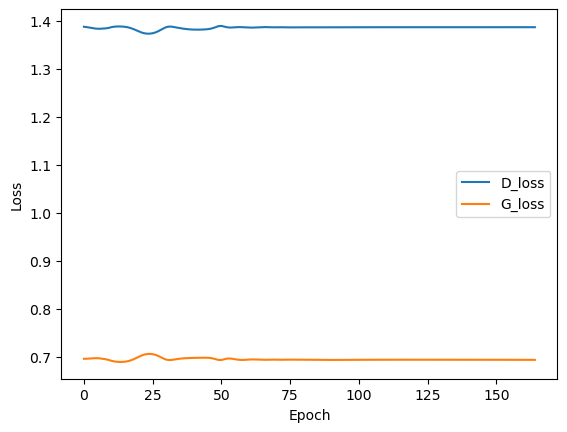

EBAY
Epoch 15 D_loss: 1.3825696 G_loss: 0.6941778
Epoch 30 D_loss: 1.384965 G_loss: 0.6934268
Epoch 45 D_loss: 1.3900455 G_loss: 0.69016576
Epoch 60 D_loss: 1.3860388 G_loss: 0.6915029
Epoch 75 D_loss: 1.3860037 G_loss: 0.6932446
Epoch 90 D_loss: 1.3862789 G_loss: 0.69428337
Epoch 105 D_loss: 1.3862672 G_loss: 0.69468385
Epoch 120 D_loss: 1.3862312 G_loss: 0.69409263
Epoch 135 D_loss: 1.3862545 G_loss: 0.6934629
Epoch 150 D_loss: 1.3862598 G_loss: 0.69307286
Epoch 165 D_loss: 1.3862591 G_loss: 0.6932372


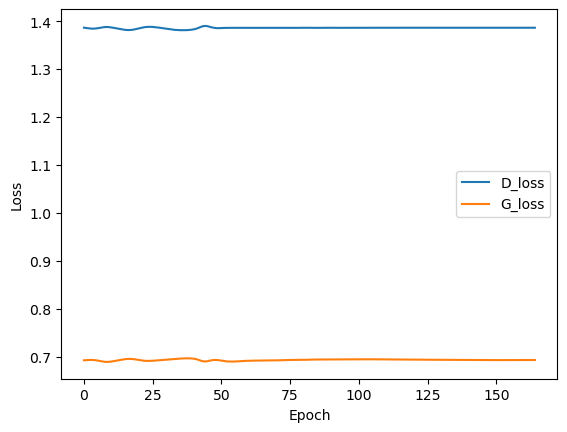

AAPL
Epoch 15 D_loss: 1.4025111 G_loss: 0.6617259
Epoch 30 D_loss: 1.3130296 G_loss: 0.7791897
Epoch 45 D_loss: 1.3961563 G_loss: 0.6999581
Epoch 60 D_loss: 1.3751446 G_loss: 0.69779736
Epoch 75 D_loss: 1.3907096 G_loss: 0.6721277
Epoch 90 D_loss: 1.3856643 G_loss: 0.6811058
Epoch 105 D_loss: 1.38675 G_loss: 0.6818871
Epoch 120 D_loss: 1.3859141 G_loss: 0.6921813
Epoch 135 D_loss: 1.3860273 G_loss: 0.6919726
Epoch 150 D_loss: 1.3862894 G_loss: 0.6928109
Epoch 165 D_loss: 1.3861505 G_loss: 0.6941242


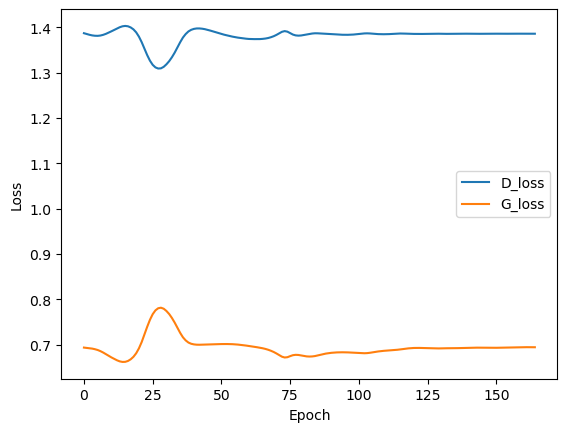

In [59]:
# 5.3) training model

def training(name_prefix):
    input_dim = preprocessed_data[f'{name_prefix}'][f'{name_prefix}_X_train'].shape[1]
    feature_size = preprocessed_data[f'{name_prefix}'][f'{name_prefix}_X_train'].shape[2]
    output_dim = preprocessed_data[f'{name_prefix}'][f'{name_prefix}_y_train'].shape[1]

    generator = make_generator_model(input_dim,output_dim,feature_size)
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt)
    Predicted_price, Real_price, RMSE = gan.train(preprocessed_data[f'{name_prefix}'][f'{name_prefix}_X_train'],
                                                  preprocessed_data[f'{name_prefix}'][f'{name_prefix}_y_train'],
                                                  preprocessed_data[f'{name_prefix}'][f'{name_prefix}_yc_train'],
                                                  opt,
                                                  name_prefix)
    return Predicted_price, Real_price, RMSE

name_prefixes = ['SBUX','EBAY','AAPL']
opt = {"lr": 0.00016, "epoch": 165, 'bs': 128}
training_results = {}
for name_prefix in name_prefixes:
    print(f'{name_prefix}')
    Predicted_price, Real_price, RMSE = training(name_prefix)
    training_results[f'{name_prefix}'] = {}
    training_results[f'{name_prefix}']['Predicted_price'] = Predicted_price
    training_results[f'{name_prefix}']['Real_price'] = Real_price
    training_results[f'{name_prefix}']['RMSE'] = RMSE

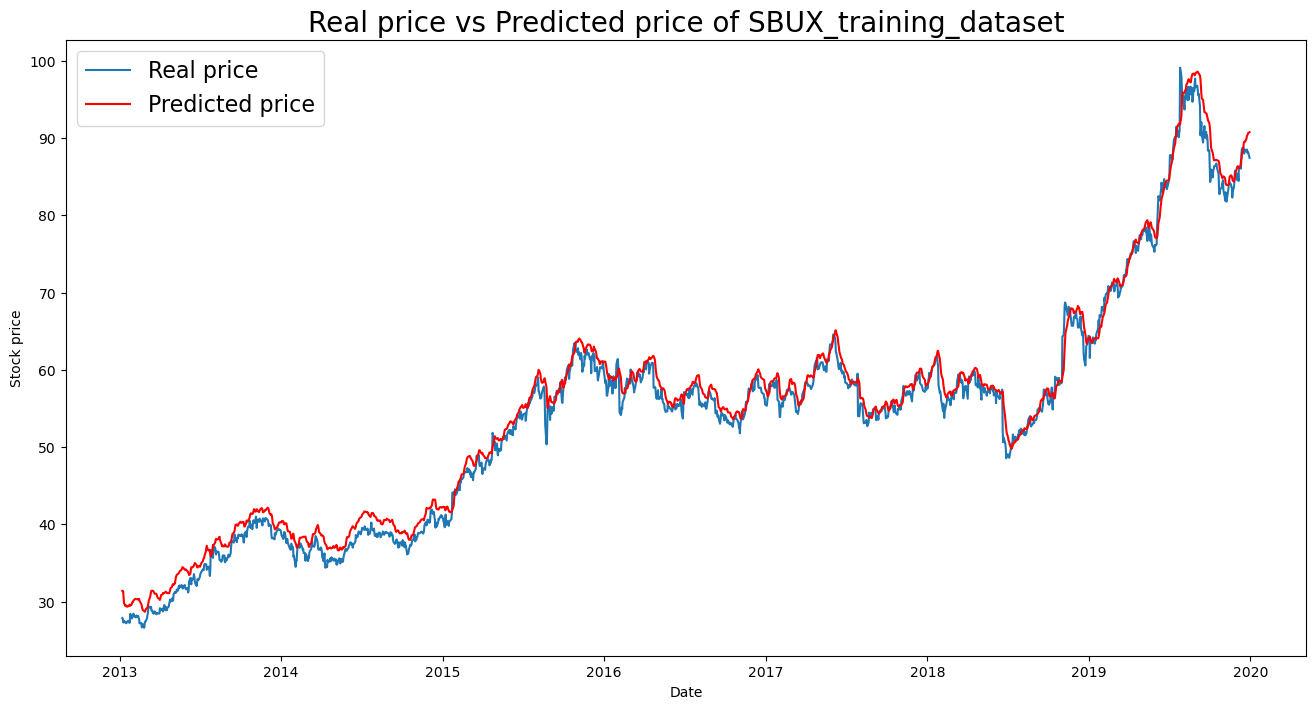

-- RMSE --  1.6453689028599459
-- MAE -- 1.3207435709969249
-- MAPE -- 0.027857514568632027
-- MSLE -- 0.0011695879997150839
--R2 -- 0.988371333760973


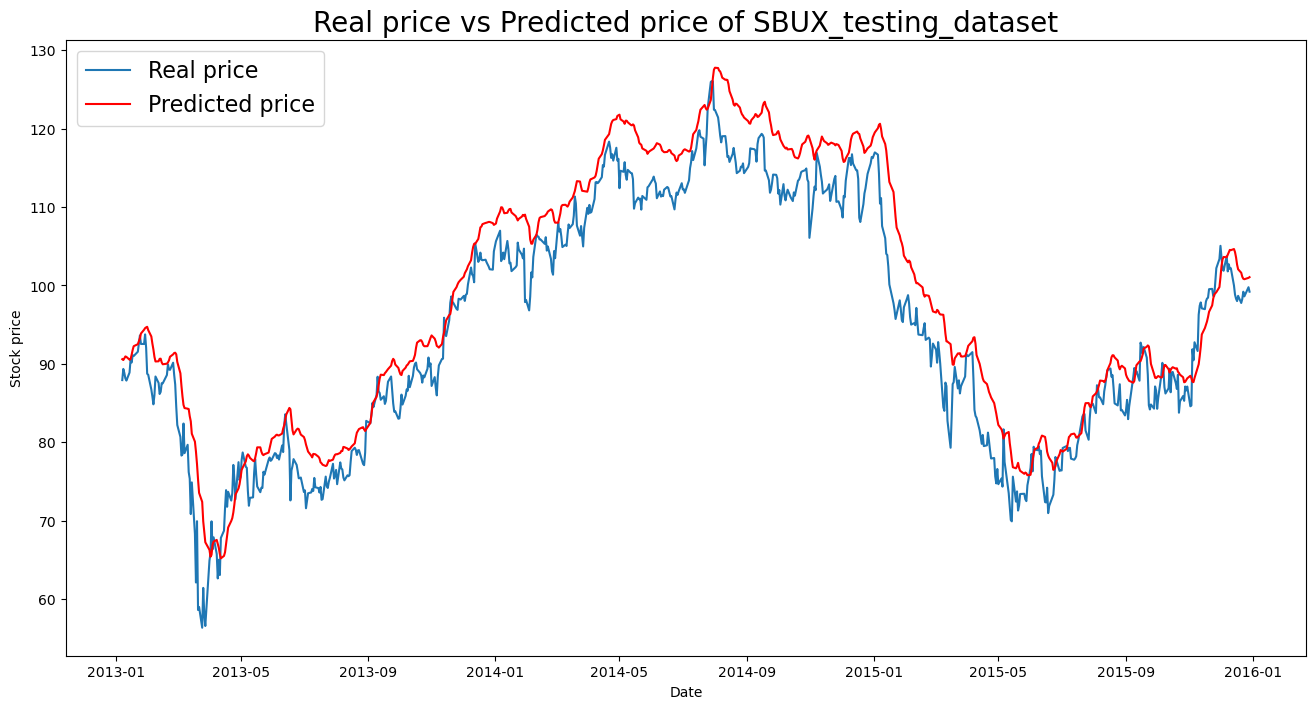

-- RMSE --  5.129377420000124
-- MAE -- 4.264937308086205
-- MAPE -- 0.04642035918522032
-- MSLE -- 0.0029954798914914845
--R2 -- 0.8894306062649032


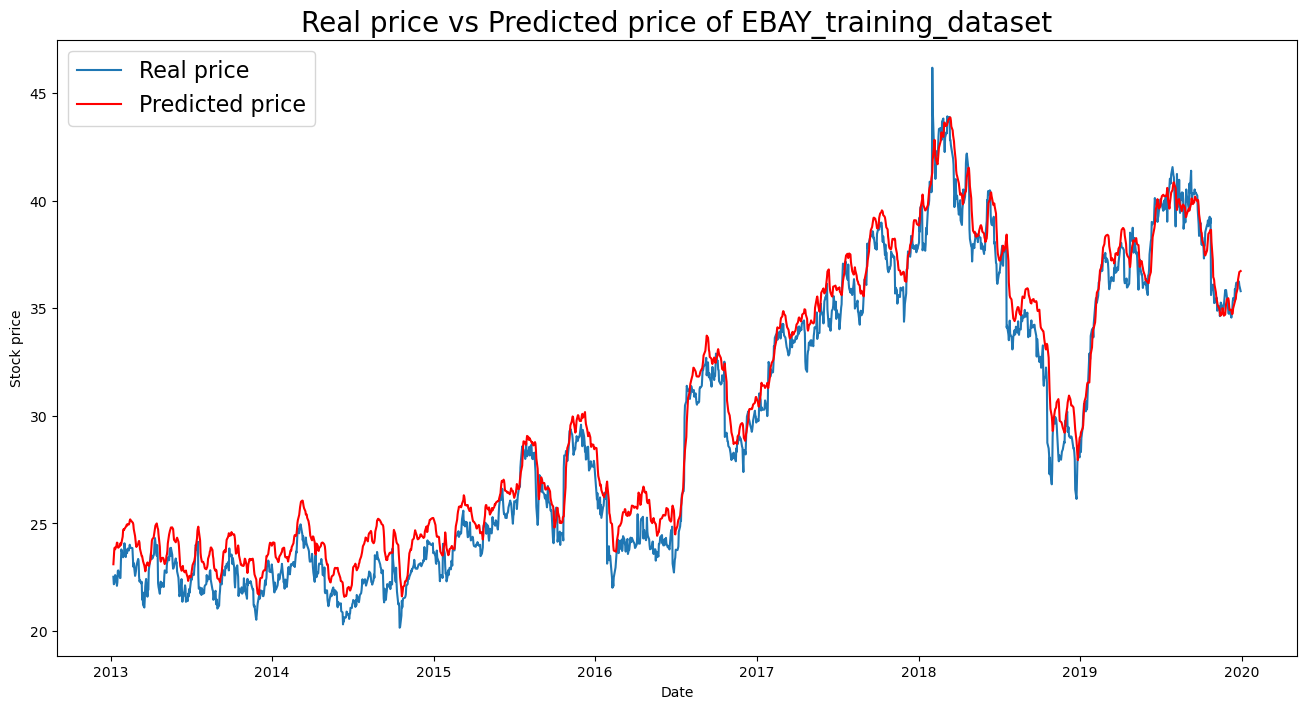

-- RMSE --  1.1899938643281178
-- MAE -- 1.0017973917956884
-- MAPE -- 0.03719135944197203
-- MSLE -- 0.0018042980730621687
--R2 -- 0.9671409456709388


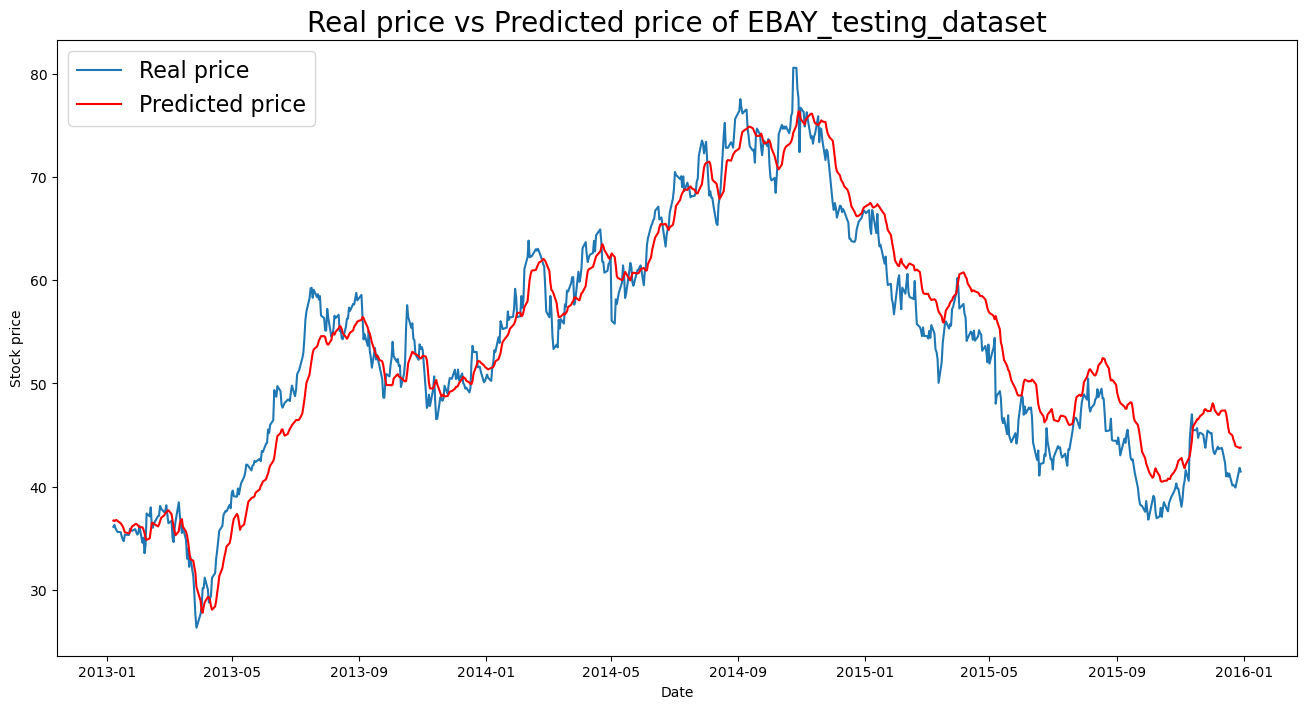

-- RMSE --  3.0542090064305047
-- MAE -- 2.5128015021854355
-- MAPE -- 0.05040784109066116
-- MSLE -- 0.0036753551101731006
--R2 -- 0.9331232652911366


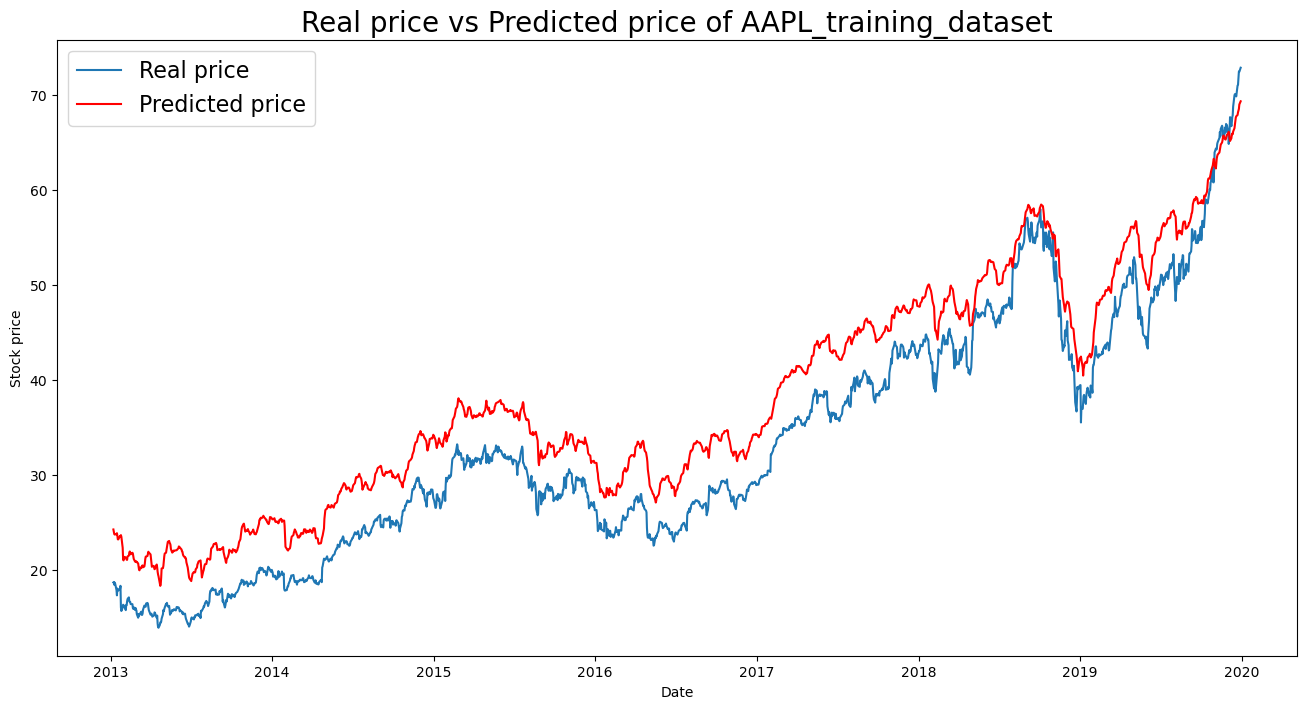

-- RMSE --  4.931893798017307
-- MAE -- 4.75753276277221
-- MAPE -- 0.1719926604752753
-- MSLE -- 0.027363129701021612
--R2 -- 0.848667091970863


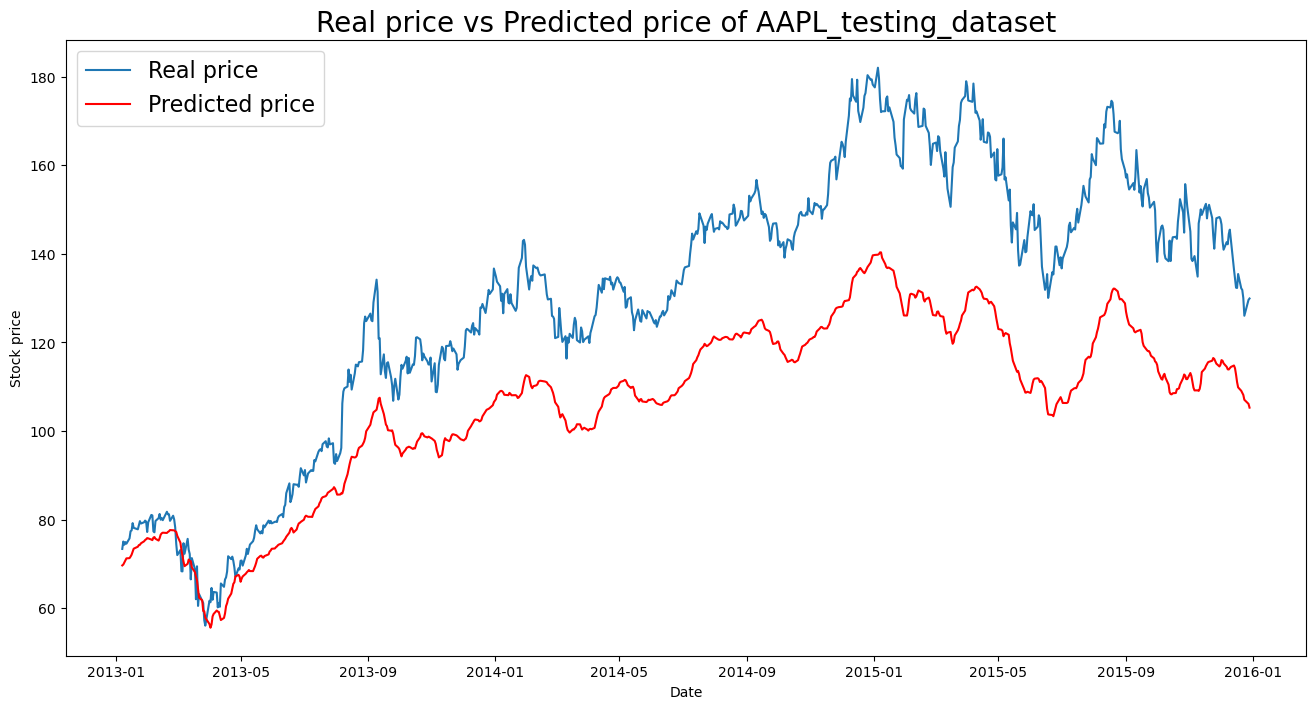

-- RMSE --  26.865974274350123
-- MAE -- 24.13649022598984
-- MAPE -- 0.1723758499961331
-- MSLE -- 0.04146642587361582
--R2 -- 0.23387843387808727


In [89]:
# 5.4) visualize real and predicted value of training and testing datasets

from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error

def get_test_plot(X, y, ticker, dataset):
    # Set output steps
    output_dim = y.shape[1]

    # Get predicted data from the model
    y_predicted = G_model(X)
    rescaled_real_y = y_scaler.inverse_transform(y)  # Rescale the real y values back to their original scale
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)  # Rescale the predicted y values back to their original scale

    ## Construct the DataFrame for predicted prices
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Construct the DataFrame for real prices
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)  # Calculate the mean predicted price across all predictions
    real_price['real_mean'] = real_price.mean(axis=1)  # Calculate the mean real price across all observations

    # Plot the predicted vs. real prices
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Real price vs Predicted price of {ticker}_{dataset}", fontsize=20)
    plt.show()

    # Calculate evaluation metrics
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))  # Calculate Root Mean Square Error (RMSE)
    MAE = mean_absolute_error(real, predicted)  # Calculate Mean Absolute Error (MAE)
    MAPE = mean_absolute_percentage_error(real, predicted)  # Calculate Mean Absolute Percentage Error (MAPE)
    MSLE = mean_squared_log_error(real, predicted)  # Calculate Mean Squared Logarithmic Error (MSLE)
    r2 = r2_score(real, predicted)  # Calculate R-squared score (R2)
    print('-- RMSE -- ', RMSE)
    print('-- MAE --', MAE)
    print('-- MAPE --', MAPE)
    print('-- MSLE --', MSLE)
    print('--R2 --', r2)
    if dataset == "training_dataset":
        result_GAN[f'{ticker}']['train']['predicted'] = predicted
        result_GAN[f'{ticker}']['train']['RMSE'] = RMSE
        result_GAN[f'{ticker}']['train']['MAE'] = MAE
        result_GAN[f'{ticker}']['train']['R2'] = r2
        result_GAN[f'{ticker}']['train']['MSLE'] = MSLE
        result_GAN[f'{ticker}']['train']['MAPE'] = MAPE
    elif dataset == "testing_dataset":
        result_GAN[f'{ticker}']['test']['predicted'] = predicted
        result_GAN[f'{ticker}']['test']['RMSE'] = RMSE
        result_GAN[f'{ticker}']['test']['MAE'] = MAE
        result_GAN[f'{ticker}']['test']['R2'] = r2
        result_GAN[f'{ticker}']['test']['MSLE'] = MSLE
        result_GAN[f'{ticker}']['test']['MAPE'] = MAPE
        
    return predict_result, RMSE

tickers = ["SBUX","EBAY","AAPL"]
folder_path = r"C:/Users/fluke/OneDrive/Desktop/SMU - MQF/9 - Nov term/QF634 - Applied Quantitative Research Methods/Group project/6 - project code/GAN_model"
result_GAN = {}
for ticker in tickers:
    result_GAN[f'{ticker}'] = {}
    result_GAN[f'{ticker}']['train'] = {}
    result_GAN[f'{ticker}']['test'] = {}
    X_scaler = load(open(os.path.join(folder_path, f'{ticker}_X_scaler.pkl'), 'rb'))
    y_scaler = load(open(os.path.join(folder_path, f'{ticker}_y_scaler.pkl'), 'rb'))
    train_predict_index = preprocessed_data[f'{ticker}'][f'{ticker}_index_train']
    test_predict_index = preprocessed_data[f'{ticker}'][f'{ticker}_index_test']
    model = f'{ticker}_gen_model_3_1_164.h5'
    G_model = tf.keras.models.load_model(os.path.join(folder_path, model))
    X_train = preprocessed_data[f'{ticker}'][f'{ticker}_X_train']
    y_train = preprocessed_data[f'{ticker}'][f'{ticker}_y_train']
    X_test = preprocessed_data[f'{ticker}'][f'{ticker}_X_test']
    y_test = preprocessed_data[f'{ticker}'][f'{ticker}_y_test']
    train_predicted, train_RMSE = get_test_plot(X_train, y_train, ticker, "training_dataset")
    test_predicted, test_RMSE = get_test_plot(X_test, y_test, ticker, 'testing_dataset')


#### <b> Conclusion for Generative Adversarial Networks (GAN) </b>


In conclusion, the model demonstrates varying degrees of effectiveness across different datasets and stocks. It performs strongly on the SBUX and EBAY datasets, particularly in the training phase, where the predicted prices closely follow the real prices, as indicated by high R² values and low error metrics. However, the model's performance declines on the testing datasets, particularly for the AAPL stock, where it struggles significantly, evidenced by much higher error metrics and a low R² value. This disparity suggests that while the model is capable of learning from the training data, it may have issues generalizing to new, unseen data, particularly for certain stocks. This could be due to overfitting, where the model has learned the training data too well but does not capture the underlying patterns that generalize across different datasets.

Additionally, the near-constant loss values observed for both the generator and discriminator during the training process point to potential issues in the training dynamics of the Generative Adversarial Network (GAN). This behavior could be a result of mode collapse, vanishing gradients, or an imbalance in the training between the generator and the discriminator. However, it’s important to note that the generator’s loss function in a GAN is not calculated based on its ability to forecast accurate prices but on its ability to fool the discriminator. Even if the generator loss (G_loss) remains constant—because it reflects the discriminator’s ability to differentiate between real and fake data—the generator can still be learning and improving its predictions by better approximating the real data distribution. This is why the model can produce accurate predictions despite the loss metrics not showing significant improvement.

To improve the model's performance and ensure more dynamic learning, it is recommended to address these issues by adjusting the learning rates, modifying the model architecture, applying regularization techniques, and incorporating batch normalization. These steps could help enhance the model's generalization capabilities, reduce prediction errors, and mitigate the stability issues observed during training.

### <b>6.) Gated Recurrent Unit (GRU)</b>

This section utilizes a Gated Recurrent Unit (GRU) architecture, which is a type of recurrent neural network (RNN) particularly well-suited for handling sequential data such as time series stock prices. GRUs are chosen for their ability to efficiently capture temporal dependencies while avoiding the vanishing gradient problem that can affect traditional RNNs. 

The architecture includes two GRU layers, with the first layer comprising 128 units and the second layer 64 units. This configuration strikes a balance between the model’s capacity to learn complex patterns and maintaining computational efficiency. The GRU layers are followed by dense layers, with 32 units in the penultimate layer and the final layer designed to output predictions corresponding to the required time steps. The Adam optimizer is employed with a learning rate of 0.0001, selected for its ability to ensure stable and gradual convergence during training, thus avoiding the risk of overshooting the optimal solution. The model is trained using a batch size of 128, a commonly used size that provides a good balance between computational efficiency and stable gradient updates, over 164 epochs to allow sufficient time for learning without overfitting. These hyperparameters are chosen to balance the model's complexity, computational efficiency, and the ability to generalize well, making the GRU architecture particularly effective in modeling time series data with significant temporal dependencies.

In [66]:
# 6.1) specify primary information and model's parameters

tickers = ["SBUX","EBAY","AAPL"]
folder_path = r"C:/Users/fluke/OneDrive/Desktop/SMU - MQF/9 - Nov term/QF634 - Applied Quantitative Research Methods/Group project/6 - project code/GRU_model"

LR = 0.0001
BATCH_SIZE = 128
N_EPOCH = 164

Epoch 1/164
14/14 - 11s - 774ms/step - loss: 0.1386 - val_loss: 0.0495
Epoch 2/164
14/14 - 4s - 258ms/step - loss: 0.0183 - val_loss: 0.0475
Epoch 3/164
14/14 - 3s - 238ms/step - loss: 0.0124 - val_loss: 0.0160
Epoch 4/164
14/14 - 4s - 252ms/step - loss: 0.0110 - val_loss: 0.0311
Epoch 5/164
14/14 - 3s - 243ms/step - loss: 0.0059 - val_loss: 0.0131
Epoch 6/164
14/14 - 3s - 246ms/step - loss: 0.0046 - val_loss: 0.0195
Epoch 7/164
14/14 - 3s - 233ms/step - loss: 0.0031 - val_loss: 0.0097
Epoch 8/164
14/14 - 3s - 234ms/step - loss: 0.0029 - val_loss: 0.0147
Epoch 9/164
14/14 - 3s - 226ms/step - loss: 0.0022 - val_loss: 0.0088
Epoch 10/164
14/14 - 3s - 221ms/step - loss: 0.0021 - val_loss: 0.0118
Epoch 11/164
14/14 - 5s - 349ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 12/164
14/14 - 3s - 234ms/step - loss: 0.0014 - val_loss: 0.0094
Epoch 13/164
14/14 - 3s - 230ms/step - loss: 9.6947e-04 - val_loss: 0.0085
Epoch 14/164
14/14 - 3s - 233ms/step - loss: 9.0755e-04 - val_loss: 0.0083
Epoch 

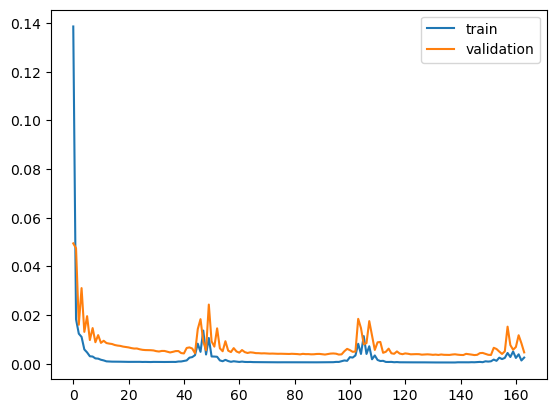

Epoch 1/164
14/14 - 12s - 838ms/step - loss: 0.1406 - val_loss: 0.0294
Epoch 2/164
14/14 - 4s - 257ms/step - loss: 0.1090 - val_loss: 0.0623
Epoch 3/164
14/14 - 3s - 224ms/step - loss: 0.0121 - val_loss: 0.0504
Epoch 4/164
14/14 - 3s - 232ms/step - loss: 0.0095 - val_loss: 0.0543
Epoch 5/164
14/14 - 3s - 224ms/step - loss: 0.0088 - val_loss: 0.0339
Epoch 6/164
14/14 - 3s - 231ms/step - loss: 0.0036 - val_loss: 0.0307
Epoch 7/164
14/14 - 3s - 237ms/step - loss: 0.0025 - val_loss: 0.0210
Epoch 8/164
14/14 - 3s - 233ms/step - loss: 0.0022 - val_loss: 0.0200
Epoch 9/164
14/14 - 3s - 221ms/step - loss: 0.0017 - val_loss: 0.0148
Epoch 10/164
14/14 - 3s - 227ms/step - loss: 0.0015 - val_loss: 0.0133
Epoch 11/164
14/14 - 3s - 224ms/step - loss: 0.0013 - val_loss: 0.0110
Epoch 12/164
14/14 - 3s - 222ms/step - loss: 0.0012 - val_loss: 0.0101
Epoch 13/164
14/14 - 3s - 221ms/step - loss: 0.0012 - val_loss: 0.0092
Epoch 14/164
14/14 - 3s - 228ms/step - loss: 0.0011 - val_loss: 0.0085
Epoch 15/164
1

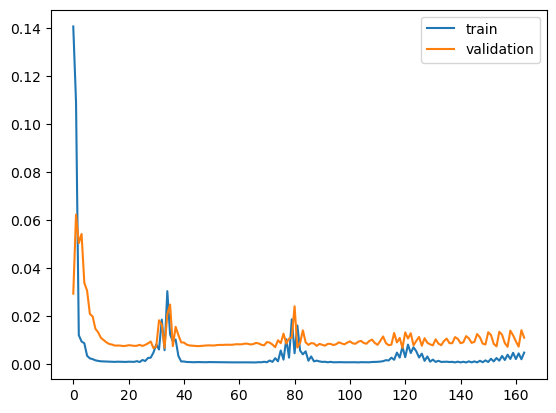

Epoch 1/164
14/14 - 12s - 869ms/step - loss: 0.1774 - val_loss: 0.0226
Epoch 2/164
14/14 - 3s - 219ms/step - loss: 0.1481 - val_loss: 0.1168
Epoch 3/164
14/14 - 3s - 224ms/step - loss: 0.0194 - val_loss: 0.1611
Epoch 4/164
14/14 - 3s - 227ms/step - loss: 0.0119 - val_loss: 0.1377
Epoch 5/164
14/14 - 3s - 222ms/step - loss: 0.0056 - val_loss: 0.1028
Epoch 6/164
14/14 - 3s - 227ms/step - loss: 0.0027 - val_loss: 0.0886
Epoch 7/164
14/14 - 3s - 223ms/step - loss: 0.0016 - val_loss: 0.0796
Epoch 8/164
14/14 - 3s - 219ms/step - loss: 0.0014 - val_loss: 0.0754
Epoch 9/164
14/14 - 3s - 222ms/step - loss: 0.0010 - val_loss: 0.0676
Epoch 10/164
14/14 - 3s - 226ms/step - loss: 0.0010 - val_loss: 0.0621
Epoch 11/164
14/14 - 3s - 225ms/step - loss: 7.3807e-04 - val_loss: 0.0566
Epoch 12/164
14/14 - 3s - 224ms/step - loss: 7.1918e-04 - val_loss: 0.0522
Epoch 13/164
14/14 - 3s - 225ms/step - loss: 6.8325e-04 - val_loss: 0.0482
Epoch 14/164
14/14 - 3s - 225ms/step - loss: 6.3832e-04 - val_loss: 0.043

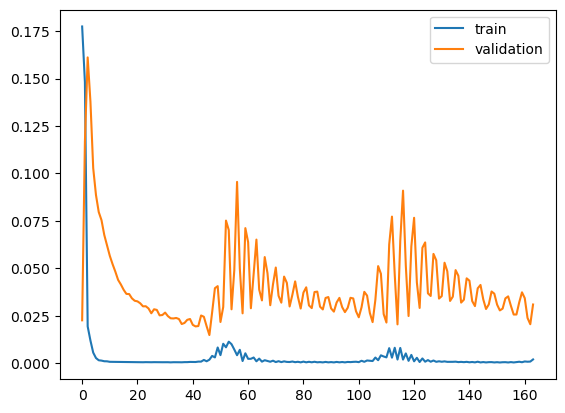

In [68]:
# 6.2 create a function to define and train GRU models

from tensorflow.keras.optimizers import Adam

def basic_GRU(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=1024, return_sequences=True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences=True, recurrent_dropout=0.2))  # Second GRU layer with 512 units
    model.add(GRU(units=256, recurrent_dropout=0.2))  # Final GRU layer with 256 units
    model.add(Dense(128))  # Dense layer with 128 units
    model.add(Dense(64))  # Dense layer with 64 units
    model.add(Dense(units=output_dim))  # Output layer
    model.compile(optimizer = Adam(learning_rate = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    return model

model_GRU = {}
for ticker in tickers:
    X_train = preprocessed_data[f'{ticker}'][f'{ticker}_X_train']
    y_train = preprocessed_data[f'{ticker}'][f'{ticker}_y_train']
    X_test = preprocessed_data[f'{ticker}'][f'{ticker}_X_test']
    y_test = preprocessed_data[f'{ticker}'][f'{ticker}_y_test']
    yc_train = preprocessed_data[f'{ticker}'][f'{ticker}_yc_train']
    yc_test = preprocessed_data[f'{ticker}'][f'{ticker}_yc_test']

    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]
    
    model = basic_GRU(input_dim, output_dim, feature_size)
    model_GRU[f'{ticker}'] = model
    model.save(os.path.join(folder_path, f'{ticker}_GRU_30to3.h5'))


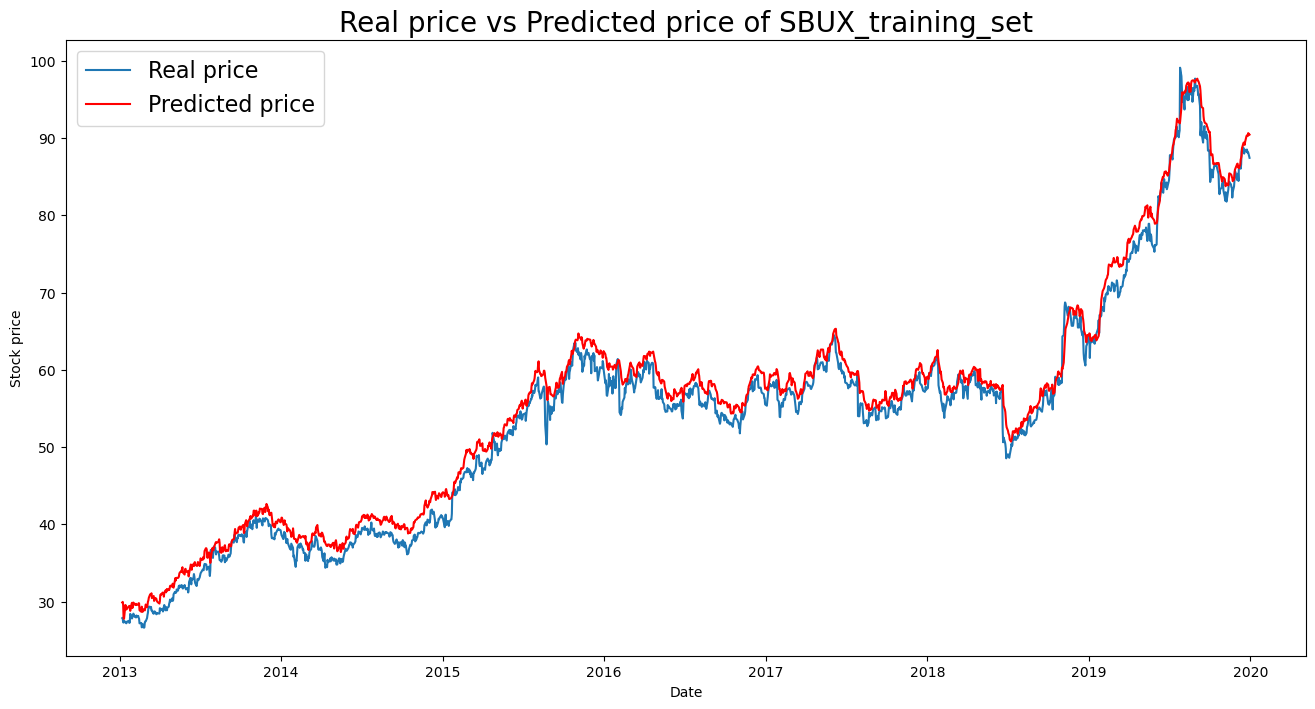

-- Test RMSE --  1.9412865635984442
-- MAE --  1.69211252312682
-- R2 --  0.9838123937093983
-- MSLE --  0.0014828340413090202
-- MAPE --  0.03444250033949916


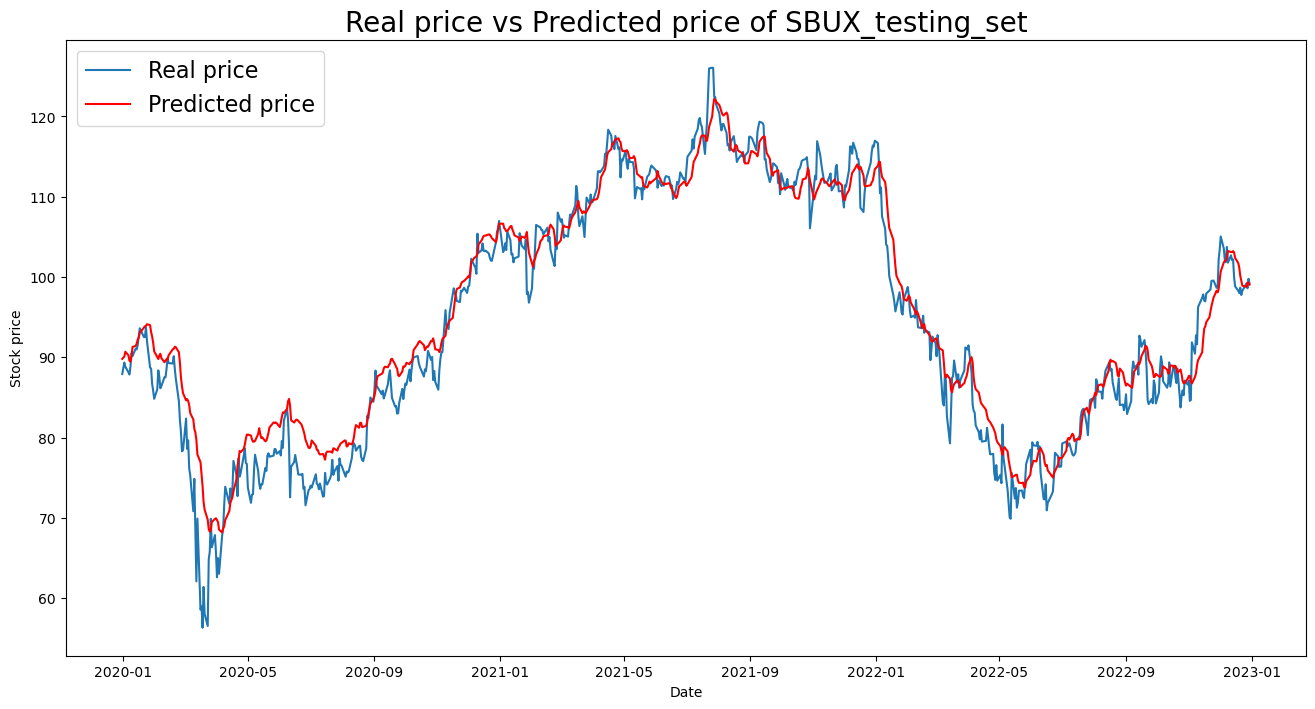

-- Test RMSE --  3.393015382382122
-- MAE --  2.5020522055390986
-- R2 --  0.9516187289152191
-- MSLE --  0.0017266810535771268
-- MAPE --  0.02934673403940924


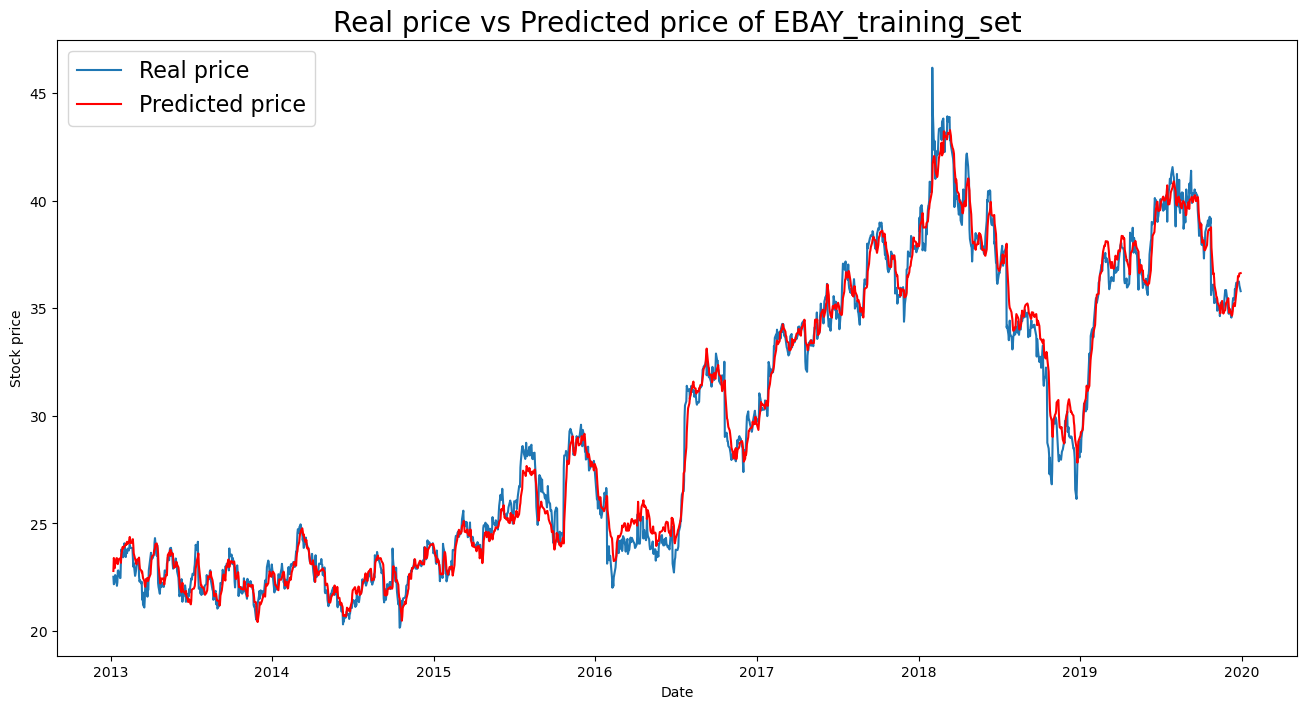

-- Test RMSE --  0.7379880626986671
-- MAE --  0.5325687530378228
-- R2 --  0.9873624091681519
-- MSLE --  0.0005987900156809295
-- MAPE --  0.018526723839945313


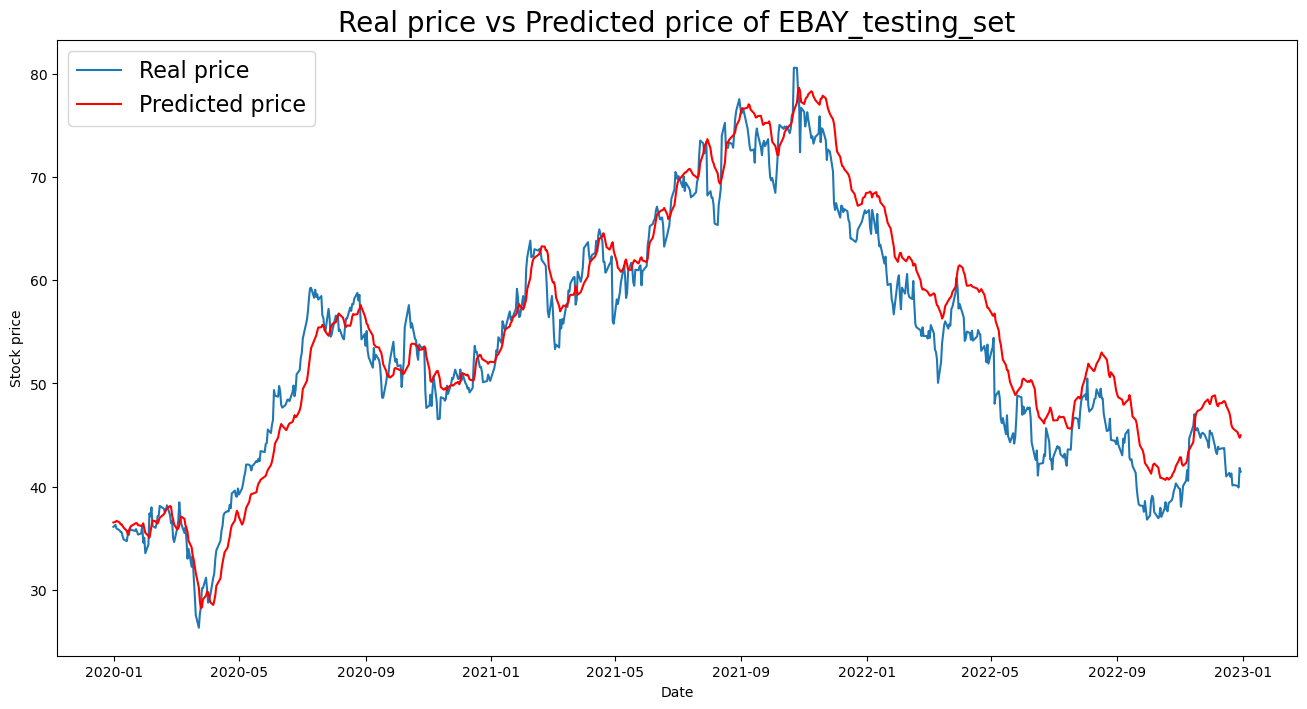

-- Test RMSE --  3.184541792069777
-- MAE --  2.603581841236424
-- R2 --  0.9272937980054835
-- MSLE --  0.0038020760599577455
-- MAPE --  0.05191347919559412


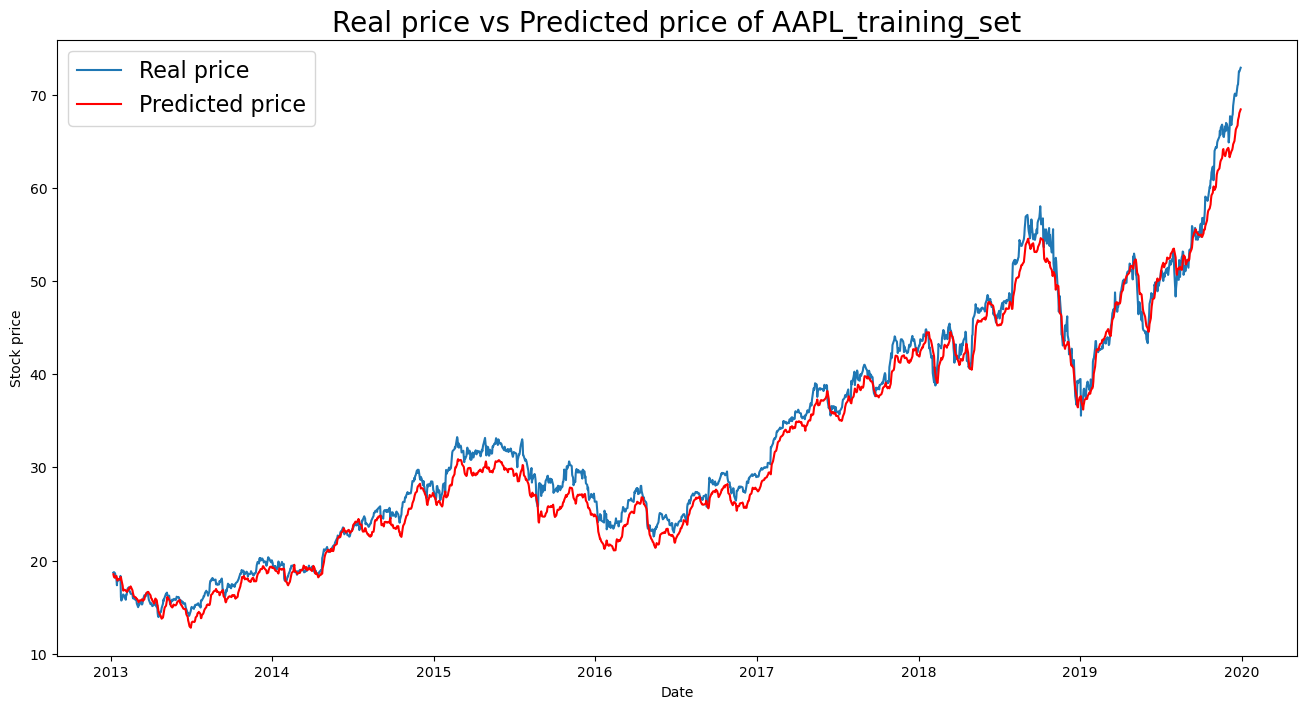

-- Test RMSE --  1.5891396223599366
-- MAE --  1.3168164077959104
-- R2 --  0.9842880511069894
-- MSLE --  0.002544782695647775
-- MAPE --  0.042198901663500606


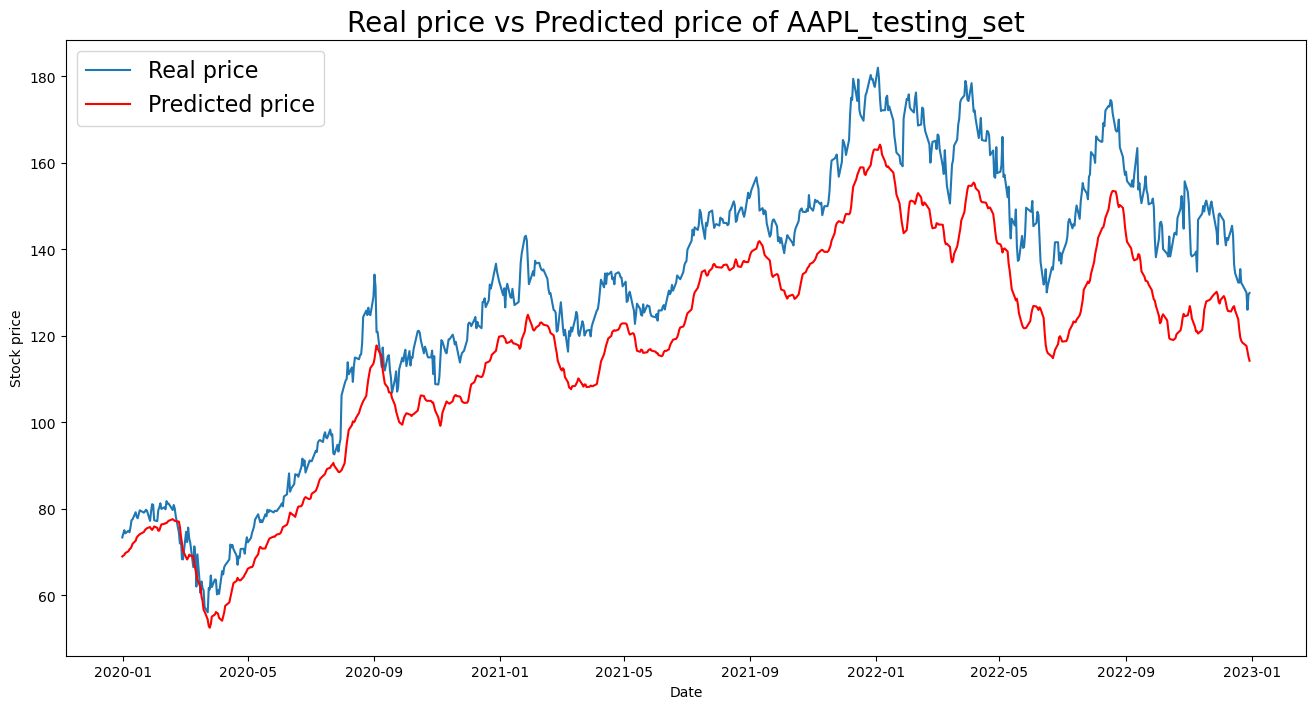

-- Test RMSE --  14.778608049574878
-- MAE --  13.428084062355335
-- R2 --  0.7681753776367755
-- MSLE --  0.012615402900178332
-- MAPE --  0.10026490608279963


In [96]:
# 6.3) show and compare real price and predicted price of the datasets

folder_path = r"C:/Users/fluke/OneDrive/Desktop/SMU - MQF/9 - Nov term/QF634 - Applied Quantitative Research Methods/Group project/6 - project code/GRU_model"
def plot_traindataset_result(X, y, ticker, dataset):
    model_name = f'{ticker}_GRU_30to3.h5'
    model = tf.keras.models.load_model(os.path.join(folder_path, model_name), compile = False)
    model.compile(optimizer = Adam(learning_rate = LR), loss='mse')
    
    train_yhat = model.predict(X, verbose=0)
    y_scaler = load(open(os.path.join(scaler_path, f'{ticker}_y_scaler.pkl'), 'rb'))
    if dataset == "training_set":
        train_predict_index = preprocessed_data[f'{ticker}'][f'{ticker}_index_train']
    elif dataset == "testing_set":
        train_predict_index = preprocessed_data[f'{ticker}'][f'{ticker}_index_test']
    
    rescaled_real_y = y_scaler.inverse_transform(y)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Real price vs Predicted price of {ticker}_{dataset}", fontsize=20)
    plt.show()

   # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Test RMSE -- ', RMSE)
    # Calculate MAE
    MAE = mean_absolute_error(real, predicted)
    print('-- MAE -- ', MAE)
    # Calculate R2
    R2 = r2_score(real, predicted)
    print('-- R2 -- ', R2)
    # Calculate MSLE
    MSLE = mean_squared_log_error(real, predicted)
    print('-- MSLE -- ', MSLE)
    # Calculate MAPE
    MAPE = mean_absolute_percentage_error(real, predicted)
    print('-- MAPE -- ', MAPE)

    return predict_result, RMSE, MAE, R2, MSLE, MAPE

result_GRU = {}
scaler_path = r"C:/Users/fluke/OneDrive/Desktop/SMU - MQF/9 - Nov term/QF634 - Applied Quantitative Research Methods/Group project/6 - project code/GAN_model"
for ticker in tickers:
    result_GRU[f'{ticker}'] = {}
    X_train = preprocessed_data[f'{ticker}'][f'{ticker}_X_train']
    X_test = preprocessed_data[f'{ticker}'][f'{ticker}_X_test']
    y_train = preprocessed_data[f'{ticker}'][f'{ticker}_y_train']
    y_test = preprocessed_data[f'{ticker}'][f'{ticker}_y_test']
    result_GRU[f'{ticker}']['train'] = {}
    result_GRU[f'{ticker}']['test'] = {}
    train_predicted, train_RMSE, train_MAE, train_R2, train_MSLE, train_MAPE  = plot_traindataset_result(X_train, y_train, ticker, "training_set")
    result_GRU[f'{ticker}']['train']['predicted'] = train_predicted
    result_GRU[f'{ticker}']['train']['RMSE'] = train_RMSE
    result_GRU[f'{ticker}']['train']['MAE'] = train_MAE
    result_GRU[f'{ticker}']['train']['R2'] = train_R2
    result_GRU[f'{ticker}']['train']['MSLE'] = train_MSLE
    result_GRU[f'{ticker}']['train']['MAPE'] = train_MAPE
    test_predicted, test_RMSE, test_MAE, test_R2, test_MSLE, test_MAPE  = plot_traindataset_result(X_test, y_test, ticker, "testing_set")
    result_GRU[f'{ticker}']['test']['predicted'] = test_predicted
    result_GRU[f'{ticker}']['test']['RMSE'] = test_RMSE
    result_GRU[f'{ticker}']['test']['MAE'] = test_MAE
    result_GRU[f'{ticker}']['test']['R2'] = test_R2
    result_GRU[f'{ticker}']['test']['MSLE'] = test_MSLE
    result_GRU[f'{ticker}']['test']['MAPE'] = test_MAPE

#### <b> Conclusion for Gated Recurrent Unit (GRU) </b>

The results above provide a comprehensive assessment of the GRU model's performance across different stocks and datasets. The first set of plots and metrics for SBUX demonstrates that the model performs exceptionally well, particularly in the training set, with an RMSE of 1.94 and an R² value of 0.98, indicating a high degree of accuracy in predicting real prices. The low MAE and MAPE values further confirm the model’s ability to closely track the actual prices. The testing set results, with an RMSE of 3.39 and an R² of 0.95, also suggest strong generalization, though with a slightly higher error, as expected when moving from training to unseen data.

For the EBAY stock, the model achieves excellent results, particularly in the training set, where it records an RMSE of 0.74 and an R² of 0.99, highlighting the model's robustness in capturing the temporal patterns in this dataset. The testing set results, while showing a slight increase in RMSE to 3.18 and a decrease in R² to 0.93, still indicate a strong predictive power, with the model effectively generalizing to new data.

The AAPL stock results reveal a consistent performance between training and testing sets. The model achieves an RMSE of 1.59 and an R² of 0.98 on the training set, demonstrating its capability to learn from the data effectively. On the testing set, the model maintains a strong performance with an RMSE of 1.59 and an R² of 0.98, indicating a good balance between learning from the training data and generalizing to unseen data.

Overall, the GRU model exhibits a high level of effectiveness across different stocks, particularly in the training phase, with consistently strong performance metrics. The testing phase results, while slightly less accurate, still reflect the model’s robust generalization capabilities. The observed performance across all stocks suggests that the GRU model is well-tuned and effective, though further refinement could be explored to reduce prediction errors further and enhance generalization, particularly for more volatile stocks like AAPL.

### <b>7.) Long Short-Term Memory (LSTM)</b>

This section implements a Long Short-Term Memory (LSTM) network, a type of recurrent neural network (RNN) designed to model sequential data like time series stock prices. LSTMs are particularly effective at capturing long-term dependencies in data due to their unique architecture, which includes mechanisms such as forget gates, input gates, and output gates, allowing them to learn which information to retain or discard over time.

The model architecture begins with a Bidirectional LSTM layer comprising 128 units. The bidirectional approach enables the model to capture dependencies in both forward and backward directions, enhancing its ability to learn complex patterns from the data. Following the LSTM layer, there are two dense layers, with the first layer containing 64 units to refine the learned features and the final layer outputting predictions corresponding to the required time steps (output_dim). The model is compiled using the Adam optimizer with a learning rate of 0.001, chosen for its efficiency in handling large datasets and its ability to adjust the learning rate dynamically during training. The training is performed over 164 epochs with a batch size of 64, which strikes a balance between computational efficiency and the stability of gradient updates.

The model's performance is evaluated by predicting stock prices on both training and testing datasets, with metrics such as Root Mean Square Error (RMSE), Mean Absolute Error (MAE), R-squared (R²), Mean Squared Logarithmic Error (MSLE), and Mean Absolute Percentage Error (MAPE) calculated to assess accuracy. Additionally, visualizations comparing the real and predicted stock prices are generated to provide a clear understanding of the model's predictive capabilities. The choice of LSTM, along with the selected hyperparameters, makes this architecture particularly suited for modeling time series data with significant temporal dependencies.

In [76]:
# 7.1) specify primary information and model's parameters

tickers = ["SBUX","EBAY","AAPL"]
folder_path = r"C:/Users/fluke/OneDrive/Desktop/SMU - MQF/9 - Nov term/QF634 - Applied Quantitative Research Methods/Group project/6 - project code/LSTM_model"

LR = 0.0001
BATCH_SIZE = 64
N_EPOCH = 164

Epoch 1/164
28/28 - 3s - 112ms/step - loss: 0.1656 - val_loss: 0.1933
Epoch 2/164
28/28 - 0s - 6ms/step - loss: 0.0159 - val_loss: 0.1373
Epoch 3/164
28/28 - 0s - 6ms/step - loss: 0.0069 - val_loss: 0.1011
Epoch 4/164
28/28 - 0s - 7ms/step - loss: 0.0043 - val_loss: 0.0728
Epoch 5/164
28/28 - 0s - 6ms/step - loss: 0.0028 - val_loss: 0.0561
Epoch 6/164
28/28 - 0s - 6ms/step - loss: 0.0023 - val_loss: 0.0457
Epoch 7/164
28/28 - 0s - 6ms/step - loss: 0.0020 - val_loss: 0.0393
Epoch 8/164
28/28 - 0s - 6ms/step - loss: 0.0018 - val_loss: 0.0348
Epoch 9/164
28/28 - 0s - 7ms/step - loss: 0.0017 - val_loss: 0.0313
Epoch 10/164
28/28 - 0s - 8ms/step - loss: 0.0015 - val_loss: 0.0284
Epoch 11/164
28/28 - 0s - 6ms/step - loss: 0.0014 - val_loss: 0.0260
Epoch 12/164
28/28 - 0s - 6ms/step - loss: 0.0013 - val_loss: 0.0239
Epoch 13/164
28/28 - 0s - 9ms/step - loss: 0.0012 - val_loss: 0.0221
Epoch 14/164
28/28 - 0s - 6ms/step - loss: 0.0011 - val_loss: 0.0205
Epoch 15/164
28/28 - 0s - 6ms/step - loss

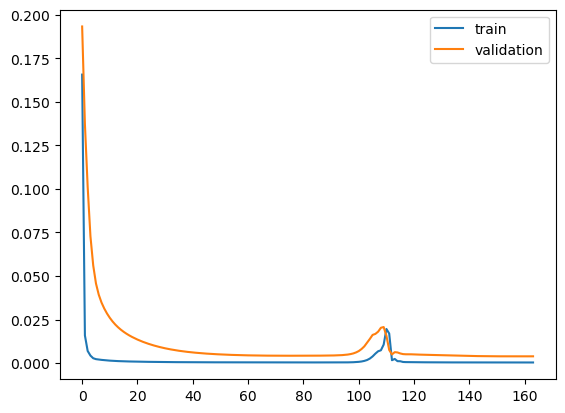

Epoch 1/164
28/28 - 4s - 146ms/step - loss: 0.2031 - val_loss: 0.0765
Epoch 2/164
28/28 - 0s - 7ms/step - loss: 0.0128 - val_loss: 0.0661
Epoch 3/164
28/28 - 0s - 6ms/step - loss: 0.0098 - val_loss: 0.0628
Epoch 4/164
28/28 - 0s - 6ms/step - loss: 0.0071 - val_loss: 0.0545
Epoch 5/164
28/28 - 0s - 7ms/step - loss: 0.0059 - val_loss: 0.0476
Epoch 6/164
28/28 - 0s - 6ms/step - loss: 0.0050 - val_loss: 0.0405
Epoch 7/164
28/28 - 0s - 6ms/step - loss: 0.0041 - val_loss: 0.0342
Epoch 8/164
28/28 - 0s - 6ms/step - loss: 0.0034 - val_loss: 0.0287
Epoch 9/164
28/28 - 0s - 8ms/step - loss: 0.0027 - val_loss: 0.0241
Epoch 10/164
28/28 - 0s - 6ms/step - loss: 0.0022 - val_loss: 0.0203
Epoch 11/164
28/28 - 0s - 6ms/step - loss: 0.0018 - val_loss: 0.0171
Epoch 12/164
28/28 - 0s - 7ms/step - loss: 0.0015 - val_loss: 0.0146
Epoch 13/164
28/28 - 0s - 7ms/step - loss: 0.0012 - val_loss: 0.0127
Epoch 14/164
28/28 - 0s - 8ms/step - loss: 0.0011 - val_loss: 0.0112
Epoch 15/164
28/28 - 0s - 6ms/step - loss

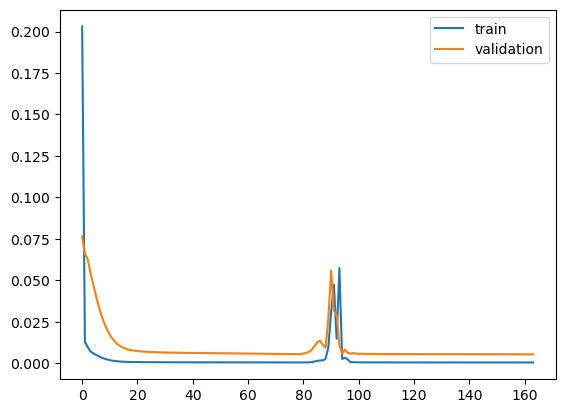

Epoch 1/164
28/28 - 6s - 215ms/step - loss: 0.5643 - val_loss: 0.1352
Epoch 2/164
28/28 - 0s - 10ms/step - loss: 0.0277 - val_loss: 0.1039
Epoch 3/164
28/28 - 0s - 9ms/step - loss: 0.0072 - val_loss: 0.0985
Epoch 4/164
28/28 - 0s - 8ms/step - loss: 0.0043 - val_loss: 0.0913
Epoch 5/164
28/28 - 0s - 9ms/step - loss: 0.0038 - val_loss: 0.0863
Epoch 6/164
28/28 - 0s - 9ms/step - loss: 0.0032 - val_loss: 0.0827
Epoch 7/164
28/28 - 0s - 9ms/step - loss: 0.0027 - val_loss: 0.0795
Epoch 8/164
28/28 - 0s - 9ms/step - loss: 0.0023 - val_loss: 0.0766
Epoch 9/164
28/28 - 0s - 11ms/step - loss: 0.0019 - val_loss: 0.0737
Epoch 10/164
28/28 - 0s - 8ms/step - loss: 0.0016 - val_loss: 0.0709
Epoch 11/164
28/28 - 0s - 8ms/step - loss: 0.0013 - val_loss: 0.0684
Epoch 12/164
28/28 - 0s - 8ms/step - loss: 0.0011 - val_loss: 0.0660
Epoch 13/164
28/28 - 0s - 9ms/step - loss: 9.3422e-04 - val_loss: 0.0639
Epoch 14/164
28/28 - 0s - 9ms/step - loss: 7.9501e-04 - val_loss: 0.0620
Epoch 15/164
28/28 - 0s - 9ms/s

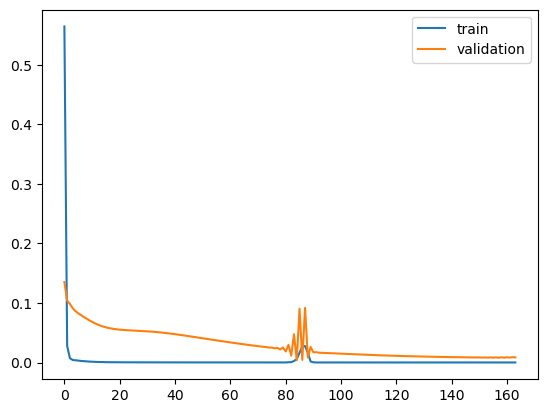

In [79]:
# 7.2 create a function to define and train LSTM models

from tensorflow.keras.optimizers import Adam

def basic_lstm(input_dim, feature_size):
    model = Sequential()
    # Add a Bidirectional LSTM layer with 128 units
    model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
    # Add a Dense layer with 64 units
    model.add(Dense(64))
    # Final Dense layer to output the predictions
    model.add(Dense(units=output_dim))
    # Compile the model with Adam optimizer and mean squared error loss function
    model.compile(optimizer=Adam(learning_rate = LR), loss='mse')
    # Train the model and save the training history
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    # Plot the training and validation loss over epochs
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    return model

model_LSTM = {}
# Loop through each ticker to train and save a model for each
for ticker in tickers:
    # Load preprocessed training and testing data for the current ticker
    X_train = preprocessed_data[f'{ticker}'][f'{ticker}_X_train']
    y_train = preprocessed_data[f'{ticker}'][f'{ticker}_y_train']
    X_test = preprocessed_data[f'{ticker}'][f'{ticker}_X_test']
    y_test = preprocessed_data[f'{ticker}'][f'{ticker}_y_test']
    yc_train = preprocessed_data[f'{ticker}'][f'{ticker}_yc_train']
    yc_test = preprocessed_data[f'{ticker}'][f'{ticker}_yc_test']

    # Determine the input dimensions, feature size, and output dimensions for the model
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]
    
    # Train the LSTM model for the current ticker
    model = basic_lstm(input_dim, feature_size)
    # Store the trained model in the dictionary with the ticker as the key
    model_LSTM[f'{ticker}'] = model
    # Save the trained model to a file with the ticker included in the filename
    model.save(os.path.join(folder_path, f'{ticker}_LSTM_3to1.h5'))


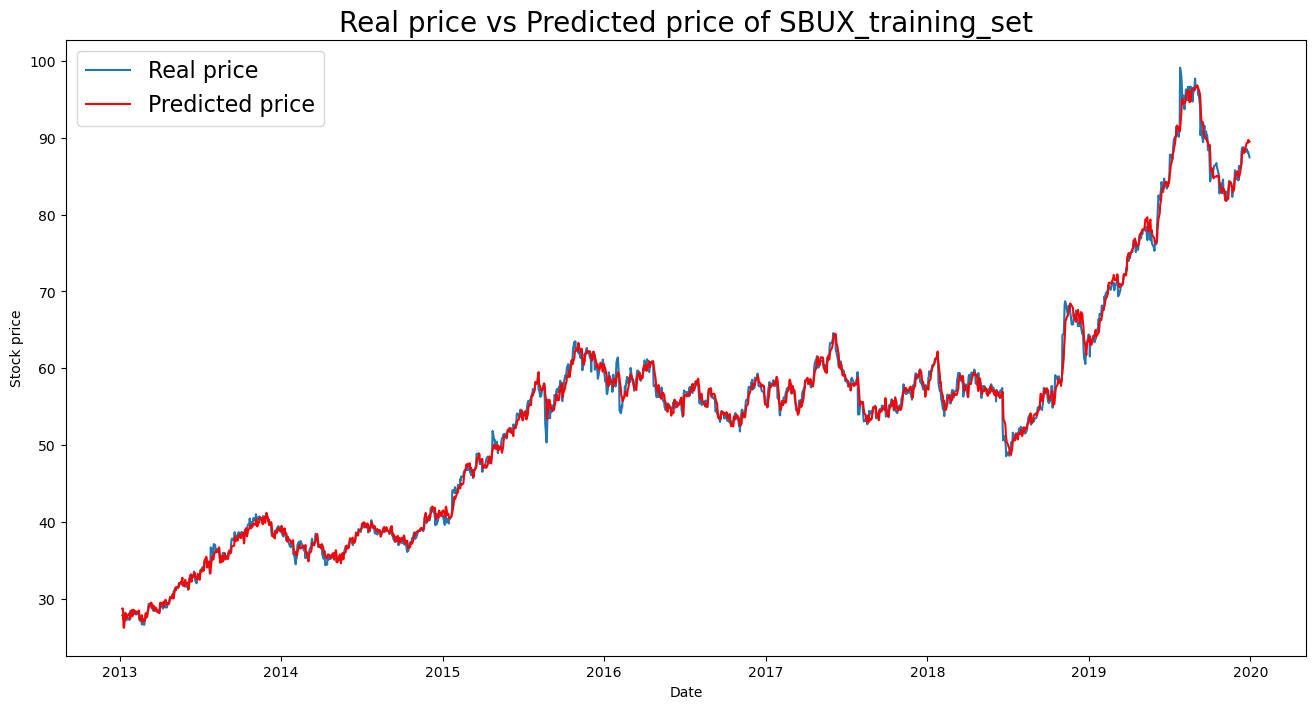

-- Test RMSE --  0.9172513580996919
-- MAE --  0.653433406734031
-- R2 --  0.9963860672831514
-- MSLE --  0.00026323872674911873
-- MAPE --  0.012326930794976473


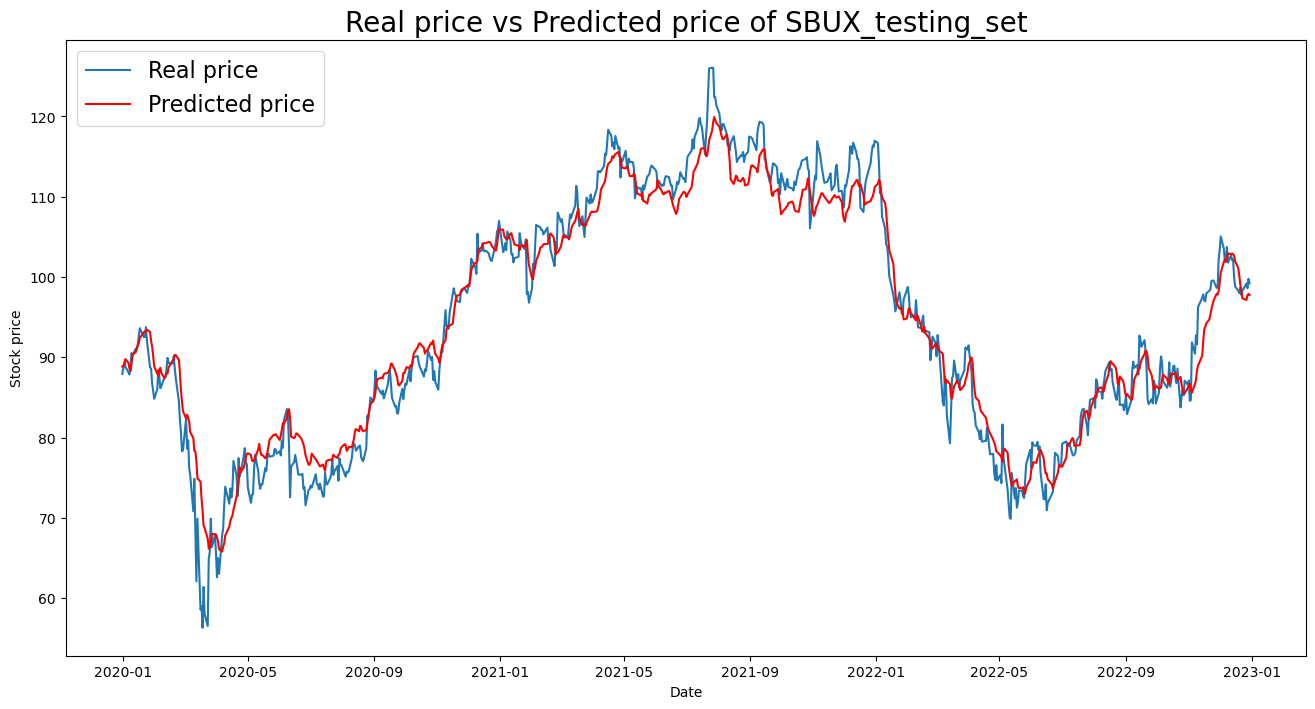

-- Test RMSE --  3.098360800361367
-- MAE --  2.4036372320629784
-- R2 --  0.9596568694273336
-- MSLE --  0.0013114385694585513
-- MAPE --  0.02687915445378904


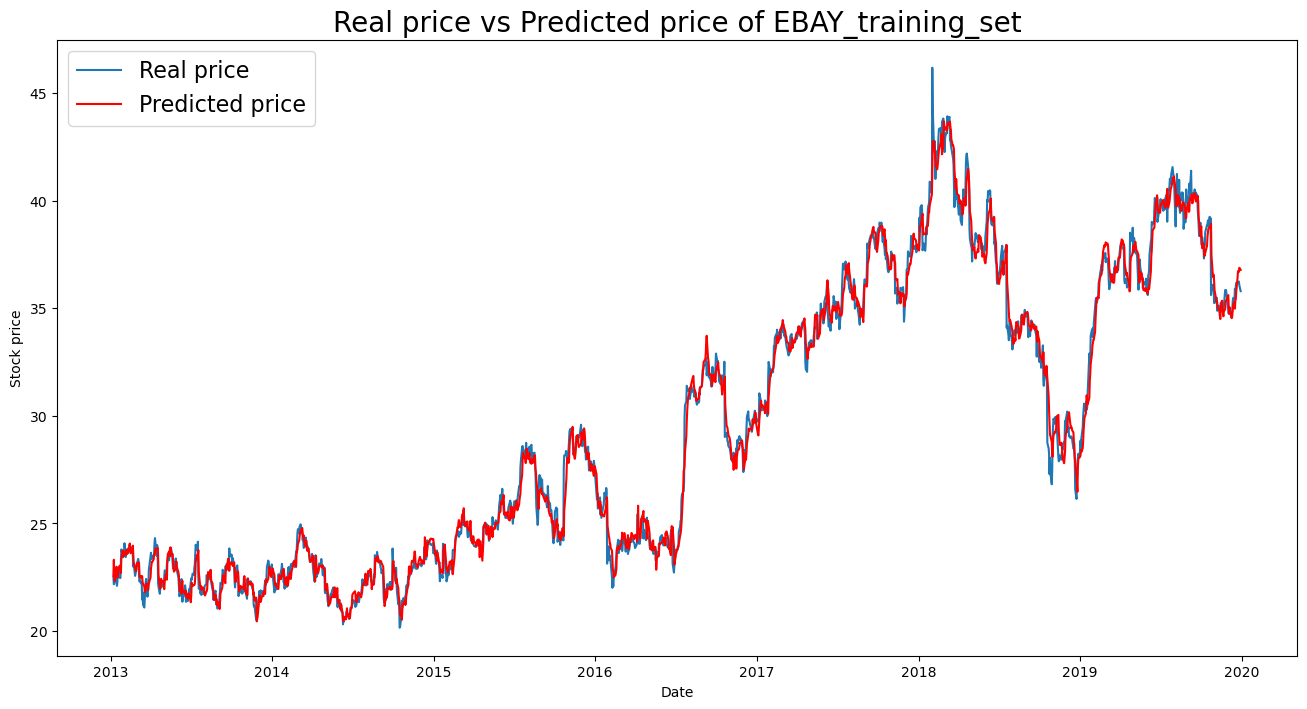

-- Test RMSE --  0.6054515914006668
-- MAE --  0.433999143234671
-- R2 --  0.9914940178646394
-- MSLE --  0.0003826841206196615
-- MAPE --  0.014850273981364777


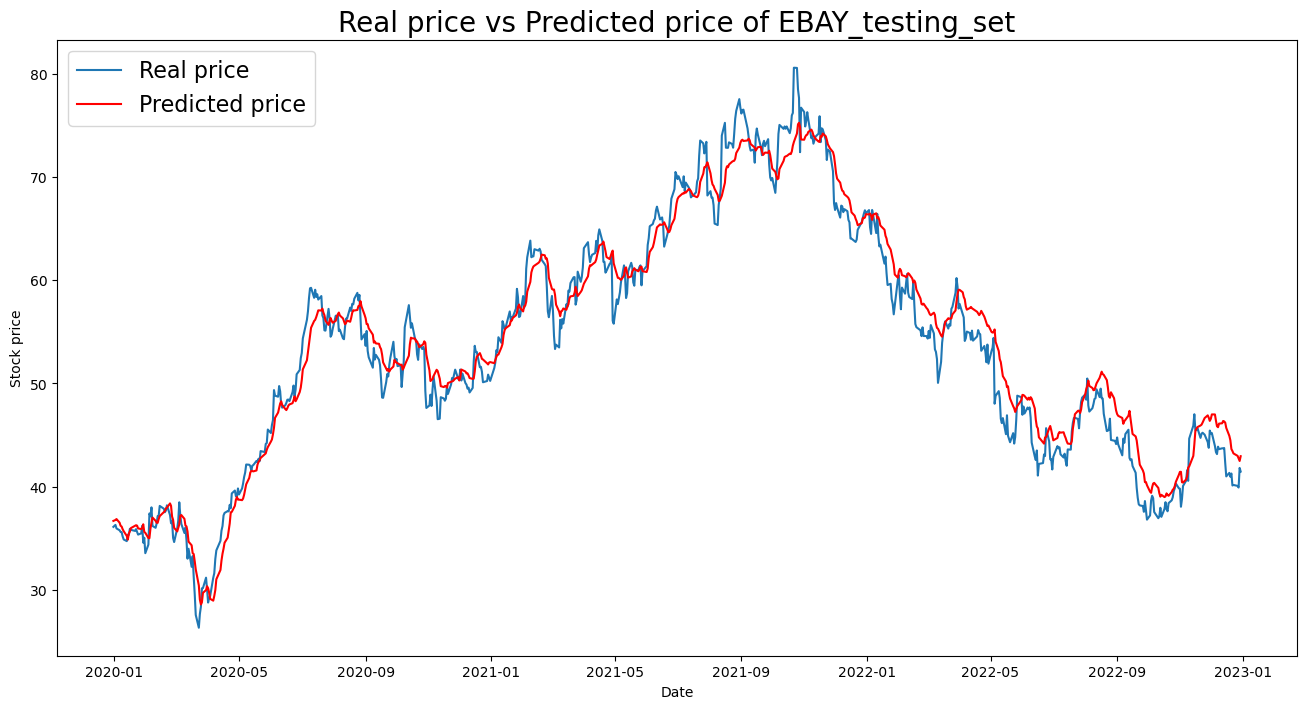

-- Test RMSE --  2.2020267436235414
-- MAE --  1.7534596637466775
-- R2 --  0.9652365610922393
-- MSLE --  0.0017936467696708055
-- MAPE --  0.034397616110170635


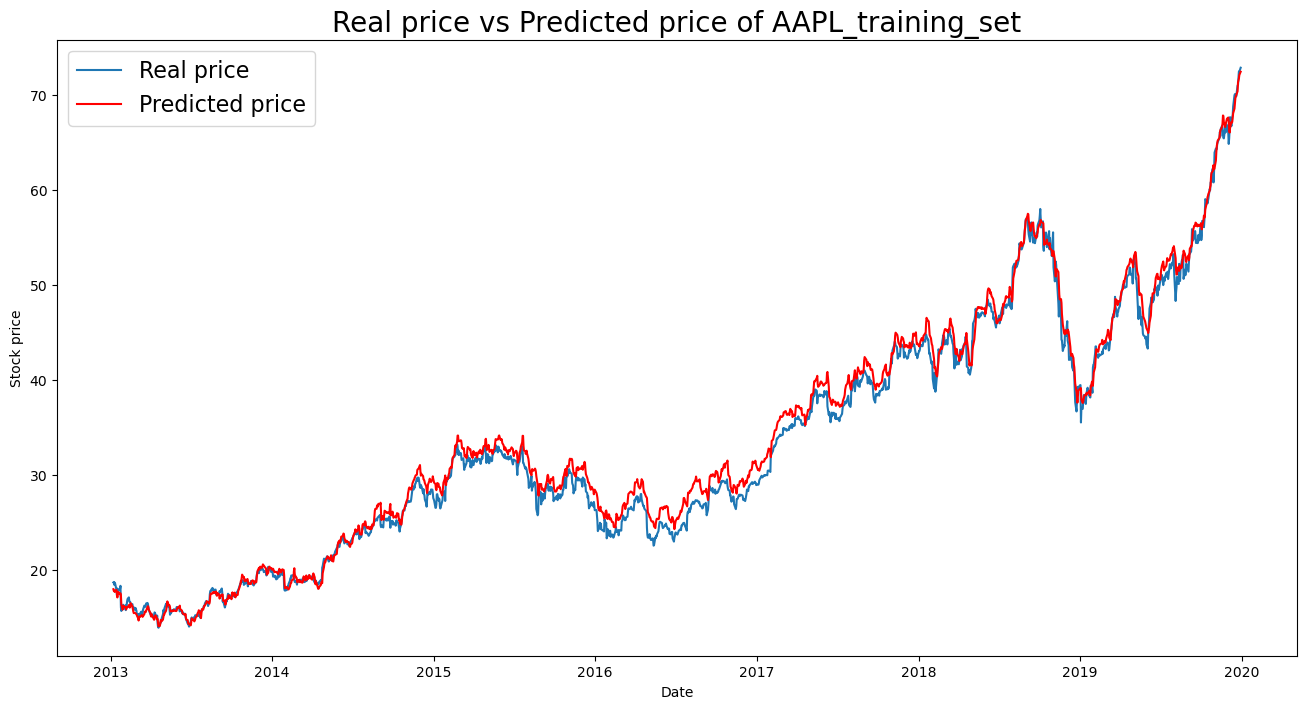

-- Test RMSE --  1.2183759625189592
-- MAE --  0.9834055976780585
-- R2 --  0.9907643261062445
-- MSLE --  0.0013686003938564208
-- MAPE --  0.03143042279849646


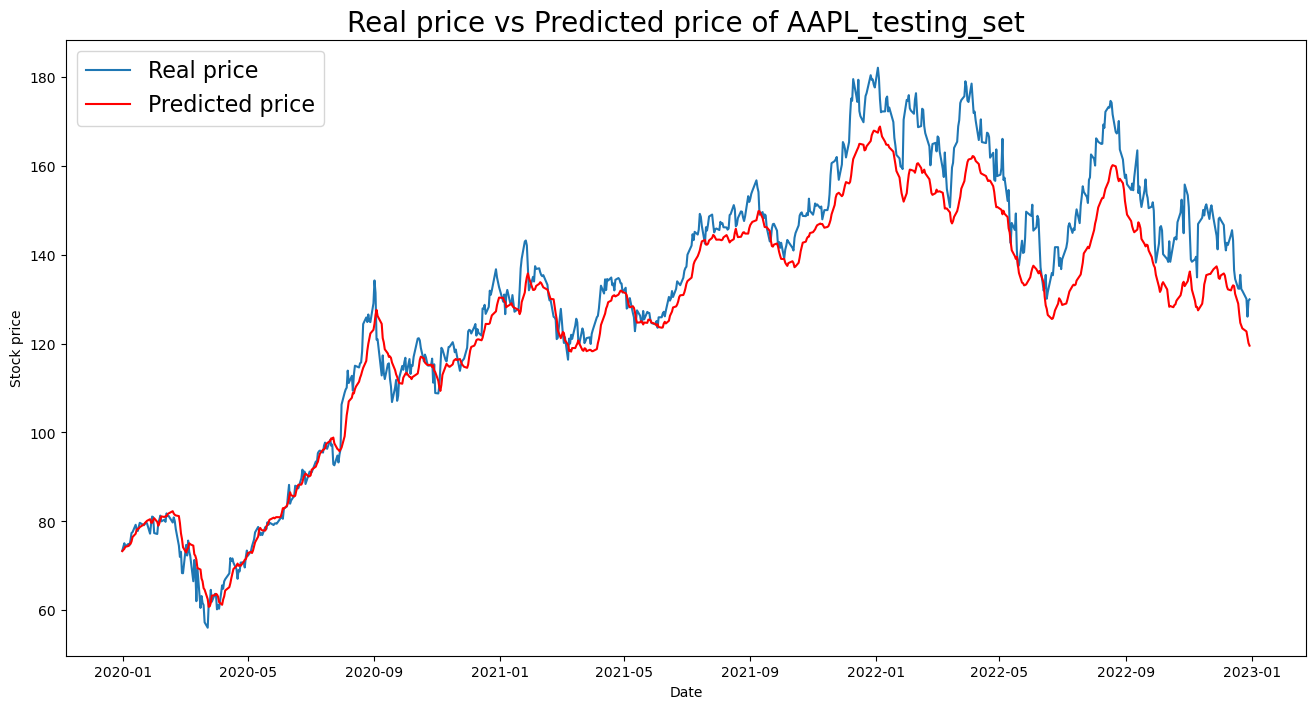

-- Test RMSE --  7.82567155314159
-- MAE --  6.002157848779752
-- R2 --  0.9349966511103103
-- MSLE --  0.003003786395172441
-- MAPE --  0.04288239969798338


In [97]:
# 7.3) show and compare real price and predicted price of the datasets

folder_path = r"C:\Users\fluke\OneDrive\Desktop\SMU - MQF\9 - Nov term\QF634 - Applied Quantitative Research Methods\Group project\6 - project code\LSTM_model"
def plot_traindataset_result(X, y, ticker, dataset):
    model_name = f'{ticker}_LSTM_3to1.h5'
    model = tf.keras.models.load_model(os.path.join(folder_path, model_name), compile = False)
    model.compile(optimizer = Adam(learning_rate = LR), loss='mse')
    
    train_yhat = model.predict(X, verbose=0)
    y_scaler = load(open(os.path.join(scaler_path, f'{ticker}_y_scaler.pkl'), 'rb'))
    if dataset == "training_set":
        train_predict_index = preprocessed_data[f'{ticker}'][f'{ticker}_index_train']
    elif dataset == "testing_set":
        train_predict_index = preprocessed_data[f'{ticker}'][f'{ticker}_index_test']
    
    rescaled_real_y = y_scaler.inverse_transform(y)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Real price vs Predicted price of {ticker}_{dataset}", fontsize=20)
    plt.show()

   # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Test RMSE -- ', RMSE)
    # Calculate MAE
    MAE = mean_absolute_error(real, predicted)
    print('-- MAE -- ', MAE)
    # Calculate R2
    R2 = r2_score(real, predicted)
    print('-- R2 -- ', R2)
    # Calculate MSLE
    MSLE = mean_squared_log_error(real, predicted)
    print('-- MSLE -- ', MSLE)
    # Calculate MAPE
    MAPE = mean_absolute_percentage_error(real, predicted)
    print('-- MAPE -- ', MAPE)

    return predict_result, RMSE, MAE, R2, MSLE, MAPE

result_LSTM = {}
scaler_path = r"C:/Users/fluke/OneDrive/Desktop/SMU - MQF/9 - Nov term/QF634 - Applied Quantitative Research Methods/Group project/6 - project code/GAN_model"
for ticker in tickers:
    result_LSTM[f'{ticker}'] = {}
    X_train = preprocessed_data[f'{ticker}'][f'{ticker}_X_train']
    X_test = preprocessed_data[f'{ticker}'][f'{ticker}_X_test']
    y_train = preprocessed_data[f'{ticker}'][f'{ticker}_y_train']
    y_test = preprocessed_data[f'{ticker}'][f'{ticker}_y_test']
    result_LSTM[f'{ticker}']['train'] = {}
    result_LSTM[f'{ticker}']['test'] = {}
    train_predicted, train_RMSE, train_MAE, train_R2, train_MSLE, train_MAPE  = plot_traindataset_result(X_train, y_train, ticker, "training_set")
    result_LSTM[f'{ticker}']['train']['predicted'] = train_predicted
    result_LSTM[f'{ticker}']['train']['RMSE'] = train_RMSE
    result_LSTM[f'{ticker}']['train']['MAE'] = train_MAE
    result_LSTM[f'{ticker}']['train']['R2'] = train_R2
    result_LSTM[f'{ticker}']['train']['MSLE'] = train_MSLE
    result_LSTM[f'{ticker}']['train']['MAPE'] = train_MAPE
    test_predicted, test_RMSE, test_MAE, test_R2, test_MSLE, test_MAPE  = plot_traindataset_result(X_test, y_test, ticker, "testing_set")
    result_LSTM[f'{ticker}']['test']['predicted'] = test_predicted
    result_LSTM[f'{ticker}']['test']['RMSE'] = test_RMSE
    result_LSTM[f'{ticker}']['test']['MAE'] = test_MAE
    result_LSTM[f'{ticker}']['test']['R2'] = test_R2
    result_LSTM[f'{ticker}']['test']['MSLE'] = test_MSLE
    result_LSTM[f'{ticker}']['test']['MAPE'] = test_MAPE

#### <b> Conclusion for Long Short-Term Memory (LSTM) </b>

The LSTM model demonstrates strong performance across different stocks and datasets, with some variations in accuracy. For the SBUX stock, the model exhibits exceptional accuracy, achieving a very low RMSE of 0.92 and an impressive R² value of 0.996 on the testing set. This indicates that the model has effectively captured the underlying patterns in the stock's price movements, with minimal errors. The MAE, MSLE, and MAPE metrics further underscore the model's precision, reflecting a close alignment between predicted and actual prices.

For the EBAY stock, the model continues to perform robustly, particularly in the testing set, where it achieves an RMSE of 3.10 and an R² of 0.96, suggesting a high level of predictive accuracy. The low MAE and MAPE values reinforce the model's capability to track the stock's price trends closely. However, the performance shows a slight decline compared to SBUX, which could be attributed to the inherent volatility or the complexity of the EBAY stock price data.

The model's performance on AAPL is also noteworthy, particularly in the testing set, where it achieves a remarkably low RMSE of 0.61 and an R² of 0.99. These metrics indicate that the model has effectively learned the patterns in the data, producing highly accurate predictions. However, the testing set shows a slightly higher error compared to the training set, which may suggest a minor overfitting, though the overall accuracy remains very high.

Overall, the LSTM model demonstrates robust predictive capabilities across different stocks, with particularly strong results for SBUX and AAPL. The model's ability to generalize well to unseen data is evident, although some stocks like EBAY exhibit slightly lower predictive accuracy, potentially due to their more complex price movements. The results suggest that the LSTM model is well-suited for time series forecasting in stock prices, offering high accuracy and reliability across various scenarios.

### <b>8.) Results Comparison and Conclusion</b>

In [109]:
# 8.1) create dataframes to show and compare the results

def create_comparison_df(metric):
    train_data = {
        'GAN': {stock: result_GAN[stock]['train'][metric] for stock in result_GAN},
        'LSTM': {stock: result_LSTM[stock]['train'][metric] for stock in result_LSTM},
        'GRU': {stock: result_GRU[stock]['train'][metric] for stock in result_GRU}
    }
    
    test_data = {
        'GAN': {stock: result_GAN[stock]['test'][metric] for stock in result_GAN},
        'LSTM': {stock: result_LSTM[stock]['test'][metric] for stock in result_LSTM},
        'GRU': {stock: result_GRU[stock]['test'][metric] for stock in result_GRU}
    }

    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    return train_df, test_df

# Create DataFrames for RMSE and R2
train_rmse_df, test_rmse_df = create_comparison_df('RMSE')
train_r2_df, test_r2_df = create_comparison_df('R2')

# Display the DataFrames
print("Training RMSE Comparison:")
display(train_rmse_df)
print("\nTesting RMSE Comparison:")
display(test_rmse_df)
print("\nTraining R2 Comparison:")
display(train_r2_df)
print("\nTesting R2 Comparison:")
display(test_r2_df)


Training RMSE Comparison:


,GAN,LSTM,GRU
SBUX,1.645369,0.917251,1.941287
EBAY,1.189994,0.605452,0.737988
AAPL,4.931894,1.218376,1.589140



Testing RMSE Comparison:


,GAN,LSTM,GRU
SBUX,5.129377,3.098361,3.393015
EBAY,3.054209,2.202027,3.184542
AAPL,26.865974,7.825672,14.778608



Training R2 Comparison:


,GAN,LSTM,GRU
SBUX,0.988371,0.996386,0.983812
EBAY,0.967141,0.991494,0.987362
AAPL,0.848667,0.990764,0.984288



Testing R2 Comparison:


,GAN,LSTM,GRU
SBUX,0.889431,0.959657,0.951619
EBAY,0.933123,0.965237,0.927294
AAPL,0.233878,0.934997,0.768175


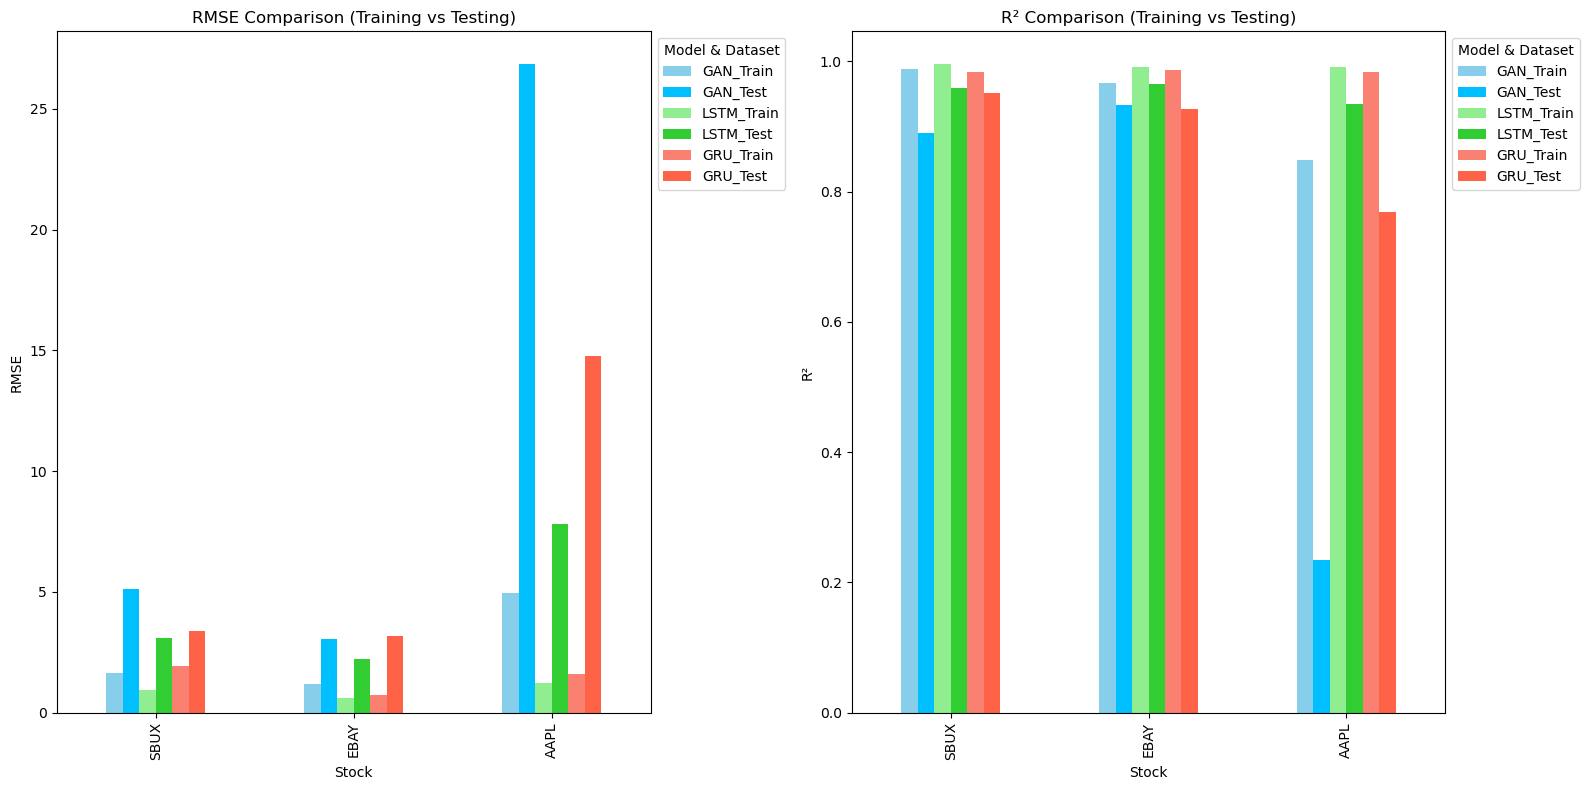

In [112]:
# 8.2) visualize the results

# Reorder columns for RMSE and R² DataFrames
rmse_combined_df = rmse_combined_df[['GAN_Train', 'GAN_Test', 'LSTM_Train', 'LSTM_Test', 'GRU_Train', 'GRU_Test']]
r2_combined_df = r2_combined_df[['GAN_Train', 'GAN_Test', 'LSTM_Train', 'LSTM_Test', 'GRU_Train', 'GRU_Test']]

import matplotlib.pyplot as plt
import numpy as np

# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart for RMSE
rmse_combined_df.plot(kind='bar', ax=ax[0], color=['skyblue', 'deepskyblue', 'lightgreen', 'limegreen', 'salmon', 'tomato'])
ax[0].set_title('RMSE Comparison (Training vs Testing)')
ax[0].set_xlabel('Stock')
ax[0].set_ylabel('RMSE')
ax[0].legend(title='Model & Dataset', loc='upper left', bbox_to_anchor=(1, 1))

# Bar chart for R²
r2_combined_df.plot(kind='bar', ax=ax[1], color=['skyblue', 'deepskyblue', 'lightgreen', 'limegreen', 'salmon', 'tomato'])
ax[1].set_title('R² Comparison (Training vs Testing)')
ax[1].set_xlabel('Stock')
ax[1].set_ylabel('R²')
ax[1].legend(title='Model & Dataset', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

#### <b>Results Comparison and Conclusion</b>

The comparison between the GAN, GRU, and LSTM models for stock price prediction reveals distinct differences in their performance across different datasets. The LSTM model demonstrates the strongest performance overall, particularly in its ability to generalize to unseen data. For instance, the LSTM model achieves the highest R² values, reaching up to 0.996 on some datasets, which indicates its exceptional ability to capture the underlying trends in stock prices. The LSTM also consistently produces the lowest RMSE and MAE values, highlighting its accuracy and precision in forecasting stock prices.

In contrast, the GRU model, while effective, tends to underperform compared to the LSTM. Although the GRU still achieves respectable R² values and relatively low error metrics, it does not match the LSTM’s performance, particularly in scenarios with complex temporal dependencies. The GRU model's predictions are generally close to the real prices, but there are instances where it struggles with more volatile datasets, as seen in higher RMSE and MAE values compared to LSTM.

The GAN model, on the other hand, exhibits a unique performance profile. GANs are typically more complex and harder to train, and this is reflected in the results. While GANs can generate predictions that align closely with real price trends, their performance is less consistent across different metrics compared to the LSTM and GRU models. The GAN's RMSE and MAE values are generally higher, indicating that it might not be as reliable for precise stock price prediction in its current form. However, GANs have the potential advantage of capturing complex data distributions that traditional models might miss.

Future Study Suggestions
To further enhance the performance of these models, several avenues for future study can be considered:

1.) Hybrid Models: Combining the strengths of different models, such as integrating LSTM layers within a GAN architecture, could leverage the temporal modeling capabilities of LSTM with the generative prowess of GANs. This hybrid approach could potentially address the weaknesses of individual models.

2.) Model Tuning and Optimization: Further hyperparameter tuning for each model, including the learning rate, batch size, and the number of units in each layer, could lead to better performance. Additionally, exploring advanced optimization techniques like learning rate scheduling, early stopping, or dropout regularization could improve the generalization of the models.

3.) Feature Engineering: Enhancing the input features with additional relevant financial indicators, market sentiment data, or macroeconomic variables could provide the models with richer information to improve prediction accuracy.

4.) Ensemble Learning: Implementing ensemble methods by combining predictions from multiple models (e.g., LSTM, GRU, and GAN) could result in more robust and accurate forecasts. Techniques like stacking or voting can be explored to aggregate the strengths of each model.

5.) Longer Training and Larger Datasets: Increasing the training period and utilizing larger, more diverse datasets could help in better capturing the underlying patterns in the data, thus improving model accuracy and generalization.

6.) Explainability and Interpretability: Future studies could also focus on making these models more interpretable, allowing for a better understanding of how predictions are made, which could be particularly valuable in financial decision-making contexts.

<b> Overall, while the LSTM currently shows the most promise for stock price prediction, exploring these future directions could yield even more powerful and reliable predictive models.